In [435]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from itertools import combinations
import math

### Read input

In [75]:
features_and_flourishing = pd.read_csv('../train_final_post_sorted/features_and_flourishing_values_pre_label_all_add_missing_post_label_43.csv')
features_and_panas = pd.read_csv('../train_final_post_sorted/features_and_panas_values_pre_label_all_add_missing_post_label_44.csv')

In [79]:
features_and_flourishing[:5]

,Unnamed: 0,uid,activity_mean,activity_var,audio_mean,audio_var,bluetooth_sum,bluetooth_var,bluetooth_mean,bluetooth_day_num,...,phonelock_var,phonelock_mean,phonelock_day_num,in_time_second,near_time_second,in_all_percentage,pre_score,post_socre,pre_label,post_label
0,0,u00,0.349241,0.924555,0.231950,0.664766,0.549544,0.732848,0.495022,0.264706,...,0.647318,0.549495,0.113636,0.348794,0.348726,0.624395,48,45.0,1,1
1,1,u01,0.483003,0.980101,0.167804,0.297014,0.890670,0.894641,0.919892,0.264706,...,0.314931,0.302449,0.204545,0.508330,0.155153,0.838135,45,46.0,1,1
2,2,u02,0.641957,0.991142,0.466649,0.540162,0.330216,0.663491,0.355197,0.000000,...,0.830154,0.861874,0.136364,0.075746,0.834783,0.152821,46,44.0,1,0
3,3,u03,1.000000,0.997714,1.000000,1.000000,1.000000,0.959529,1.000000,0.735294,...,0.110290,0.643577,0.659091,0.255011,0.985731,0.012731,34,31.0,0,0
4,4,u04,0.000000,0.946310,0.000000,0.830575,0.489869,0.673099,0.420698,0.264706,...,0.345974,0.023715,0.250000,0.406917,0.669608,0.361376,27,33.0,0,0


In [80]:
features_and_panas[:5]

,Unnamed: 0,uid,activity_mean,activity_var,audio_mean,audio_var,bluetooth_sum,bluetooth_var,bluetooth_mean,bluetooth_day_num,...,near_time_second,in_all_percentage,pre_positive,post_positive,pre_negative,post_negative,pre_positive_label,post_positive_label,pre_negative_label,post_negative_label
0,0,u00,0.349241,0.924555,0.231950,0.664766,0.549544,0.732848,0.495022,0.264706,...,0.348726,0.624395,32,31.0,33,24.0,1,1,1,1
1,1,u01,0.483003,0.980101,0.167804,0.297014,0.890670,0.894641,0.919892,0.264706,...,0.155153,0.838135,30,27.0,19,17.0,1,0,1,0
2,2,u02,0.641957,0.991142,0.466649,0.540162,0.330216,0.663491,0.355197,0.000000,...,0.834783,0.152821,23,28.0,15,13.0,1,1,1,0
3,3,u03,1.000000,0.997714,1.000000,1.000000,1.000000,0.959529,1.000000,0.735294,...,0.985731,0.012731,30,25.0,27,20.0,1,0,1,0
4,4,u04,0.000000,0.946310,0.000000,0.830575,0.489869,0.673099,0.420698,0.264706,...,0.669608,0.361376,27,34.0,14,19.0,1,1,1,0


### Prepare features and labels

In [81]:
# get flourishing features and label
X_flourishing = features_and_flourishing.iloc[:,2:].drop(columns = ['pre_score', 'post_socre',
                                                                 'pre_label', 'post_label'])
y_flourishing = features_and_flourishing['post_label']

In [82]:
# get panas features
X_panas = features_and_panas.iloc[:,2:29]
# get panas positive label
y_panas_pos = features_and_panas['post_positive_label']
# get panas negative label
y_panas_neg = features_and_panas['post_negative_label']

### Train with model SVM

In [446]:
def pred_post_svc(X, y, c = 1.0):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, 
    #                                test_size=0.33, random_state=164520)
    
    X_train = X.iloc[:30,:]
    X_test = X.iloc[30:,:]
    y_train = y[:30]
    y_test = y[30:]
    
    # kernel If none is given, ‘rbf’ will be used. kernel = 'linear',
    classifier = SVC(kernel = 'linear', gamma='auto', C = c)
    classifier.fit(X_train, y_train)
    
    train_pred = classifier.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    print('Train accuracy:', train_acc)

    test_pred = classifier.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print('Test accuracy:', test_acc)
    
    # X_train 4 fold
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=4)
    print('cv accuracies:', cv_scores)
    print('min cv acc:', min(cv_scores))
    
    # f1, recall, precision
    print(classification_report(y_test, test_pred))
    
    # all metrics
    auc_score = evaluation_metrics(y_test, test_pred)
    
    # plot feature importance
    feature_names = X.columns
    top_15_features = feature_importances(classifier.coef_[0], feature_names)
    
    return list(top_15_features), auc_score, min(cv_scores), test_acc

In [459]:
def pred_post_svc_no_output(X, y, c = 1.0):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, 
    #                                test_size=0.33, random_state=164520)
    
    X_train = X.iloc[:30,:]
    X_test = X.iloc[30:,:]
    y_train = y[:30]
    y_test = y[30:]
    
    # kernel If none is given, ‘rbf’ will be used. kernel = 'linear',
    classifier = SVC(kernel = 'linear', C = c)
    classifier.fit(X_train, y_train)
    
    train_pred = classifier.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)

    test_pred = classifier.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    
    # X_train 4 fold
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=4)

    # all metrics
    auc_score = metrics.roc_auc_score(y_test, test_pred)

    return auc_score, min(cv_scores), test_acc

In [448]:
def plot_auc_roc(classifier, X_test, y_test):
    # Ref: http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/
    probs = classifier.predict_proba(X_test)
    probs = probs[:, 1]
    #print(probs)
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.show()
    auc_score = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc_score)

In [454]:
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
def feature_importances(coef, names):
    coef = [abs(c) for c in coef]
    importances,names = zip(*sorted(zip(coef,names)))
    top_15_features = names[13:]
    plt.barh(range(len(names)), importances, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    return top_15_features

In [450]:
def evaluation_metrics(test,pred):
    auc_score = metrics.roc_auc_score(test,pred)
    logloss = metrics.log_loss(test,pred)
    accuracy = metrics.accuracy_score(test,pred)
    F_Measure = metrics.f1_score(test,pred)
    precision = metrics.precision_score(test,pred)
    recall = metrics.recall_score(test,pred)
    print('auc_score, logloss, accuracy, F_Measure, precision, recall')
    all_metrics = [auc_score,logloss,accuracy,F_Measure,precision,recall]
    for m in all_metrics:
        print('{0:0.2f}'.format(m), end = '\t')
    return auc_score

In [451]:
def find_best_feature(X, y):
    auc_score = 0
    min_cv_score = 0
    test_acc = 0
    best_f = ''
    for f in X.columns:
        curr_feature = X[[f]]
        curr_auc, curr_min_cv, curr_test_acc = pred_post_svc(curr_feature, y)
        if curr_auc > auc_score and curr_min_cv > min_cv_score and \
                curr_test_acc > test_acc:
            auc_score = curr_auc
            min_cv_score = curr_min_cv
            test_acc = curr_test_acc
            best_f = f
    return best_f, auc_score, min_cv_score, test_acc

In [443]:
def feature_selector(X, y, initial_fs, auc_score = 0, min_cv_score = 0, test_acc = 0):
    all_cols = X.columns
    curr_cols = initial_fs
    for col in all_cols:
        if col not in curr_cols:
            curr_cols.append(col)
            curr_feature = X[curr_cols]
            curr_auc, curr_min_cv, curr_test_acc = pred_post_svc(curr_feature, y)

            if curr_auc > auc_score and curr_min_cv > min_cv_score and \
                curr_test_acc > test_acc:
                auc_score = curr_auc
                min_cv_score = curr_min_cv
                test_acc = curr_test_acc
            else:
                curr_cols.remove(col)
    return curr_cols, auc_score, min_cv_score, test_acc

In [444]:
def feature_selector_equal(X, y, initial_fs, auc_score = 0, min_cv_score = 0, test_acc = 0):
    all_cols = X.columns
    curr_cols = initial_fs
    for col in all_cols:
        if col not in curr_cols:
            curr_cols.append(col)
            curr_feature = X[curr_cols]
            curr_auc, curr_min_cv, curr_test_acc = pred_post_svc(curr_feature, y)

            if curr_auc >= auc_score and curr_min_cv >= min_cv_score and \
                curr_test_acc >= test_acc:
                auc_score = curr_auc
                min_cv_score = curr_min_cv
                test_acc = curr_test_acc
            else:
                curr_cols.remove(col)
    return curr_cols, auc_score, min_cv_score, test_acc

Train accuracy: 0.8333333333333334
Test accuracy: 0.46153846153846156
cv accuracies: [0.66666667 0.71428571 0.71428571 0.42857143]
min cv acc: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.29      0.50      0.36         4
           1       0.67      0.44      0.53         9

    accuracy                           0.46        13
   macro avg       0.48      0.47      0.45        13
weighted avg       0.55      0.46      0.48        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.47	18.60	0.46	0.53	0.67	0.44	

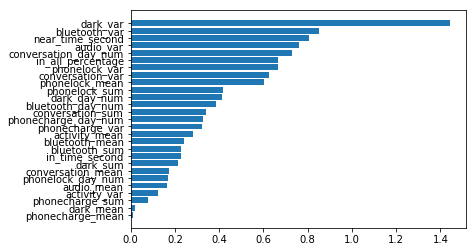

In [455]:
top_15, auc_score, min_cv_score, test_acc = pred_post_svc(X_flourishing, y_flourishing)

In [456]:
top_15

['phonecharge_day_num',
 'conversation_sum',
 'bluetooth_day_num',
 'dark_day_num',
 'phonelock_sum',
 'phonelock_mean',
 'conversation_var',
 'phonelock_var',
 'in_all_percentage',
 'conversation_day_num',
 'audio_var',
 'near_time_second',
 'bluetooth_var',
 'dark_var']

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

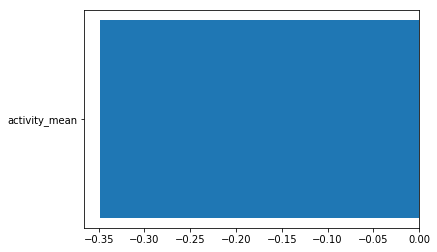

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

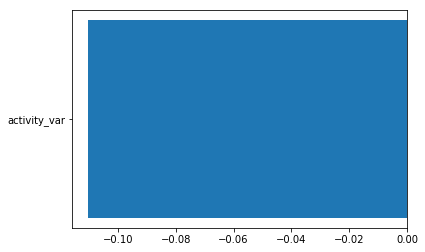

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

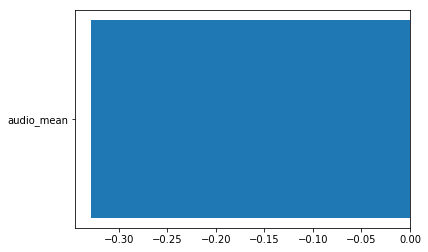

Train accuracy: 0.7
Test accuracy: 0.23076923076923078
cv accuracies: [0.55555556 0.57142857 0.71428571 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.25      0.75      0.38         4
           1       0.00      0.00      0.00         9

    accuracy                           0.23        13
   macro avg       0.12      0.38      0.19        13
weighted avg       0.08      0.23      0.12        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.38	26.57	0.23	0.00	0.00	0.00	

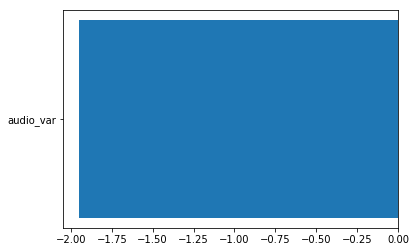

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

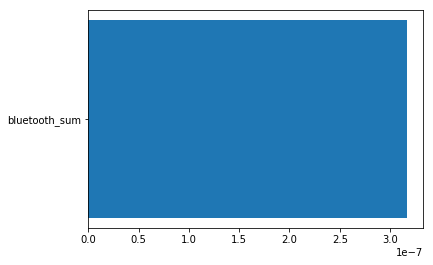

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

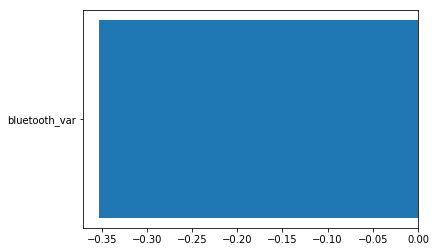

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

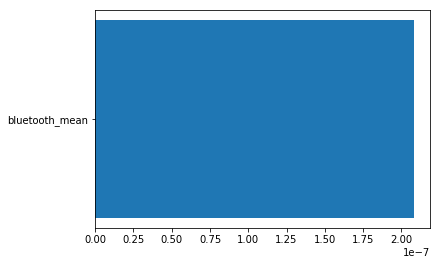

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

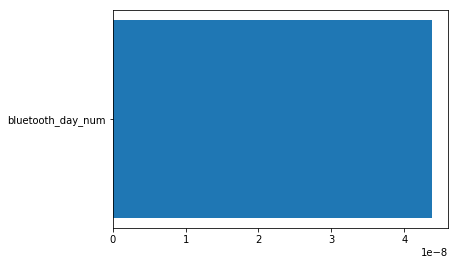

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

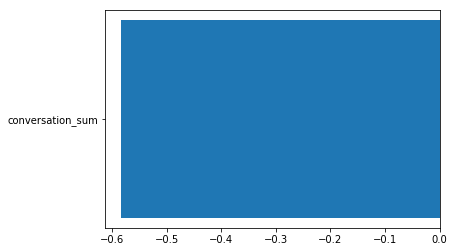

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

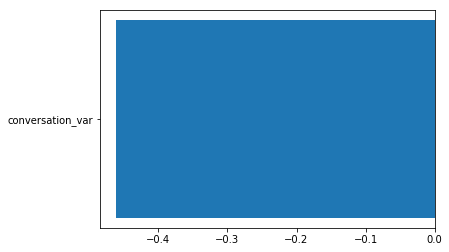

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

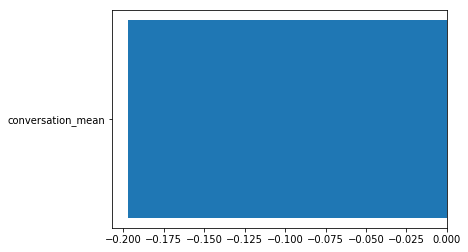

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

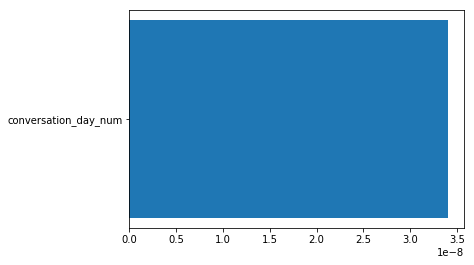

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

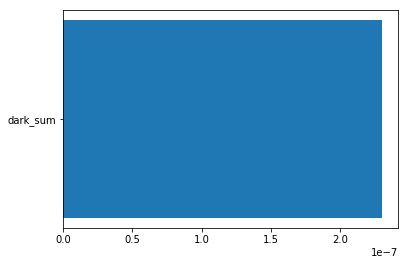

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

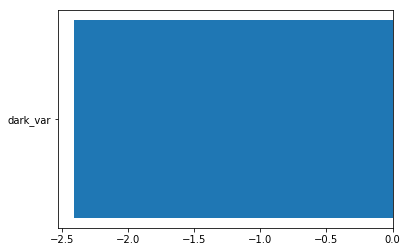

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

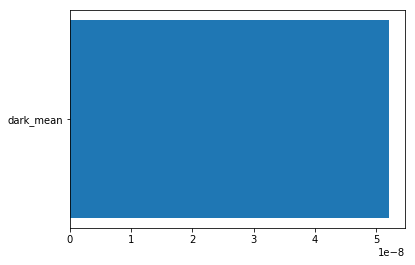

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

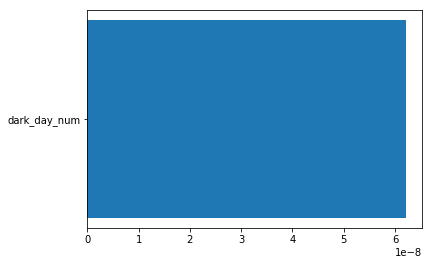

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

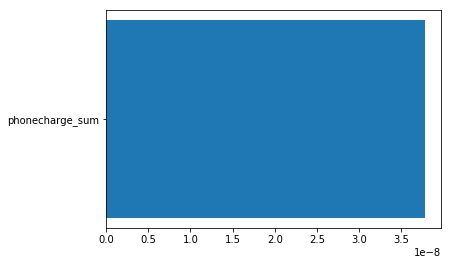

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

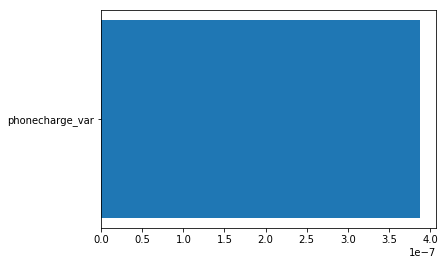

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

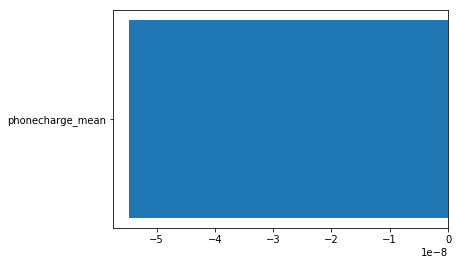

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

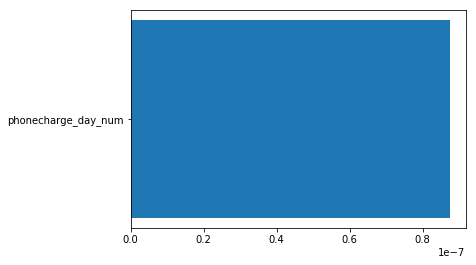

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

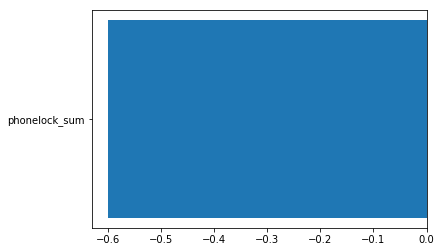

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

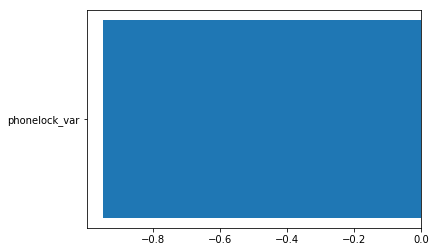

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

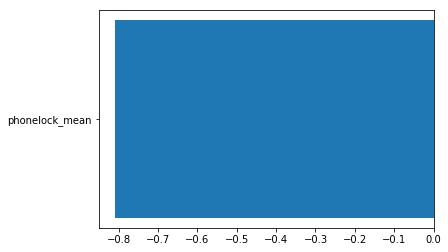

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

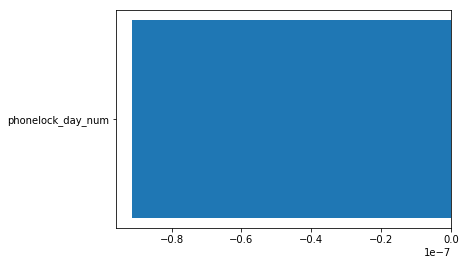

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

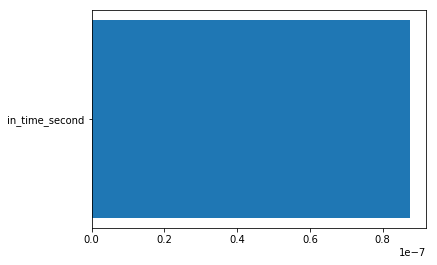

Train accuracy: 0.6
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.27      0.75      0.40         4
           1       0.50      0.11      0.18         9

    accuracy                           0.31        13
   macro avg       0.39      0.43      0.29        13
weighted avg       0.43      0.31      0.25        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.43	23.91	0.31	0.18	0.50	0.11	

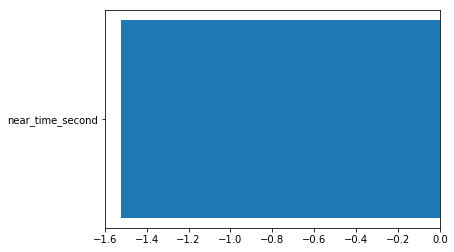

Train accuracy: 0.6
Test accuracy: 0.23076923076923078
cv accuracies: [0.55555556 0.57142857 0.57142857 0.42857143]
min cv acc: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.25      0.75      0.38         4
           1       0.00      0.00      0.00         9

    accuracy                           0.23        13
   macro avg       0.12      0.38      0.19        13
weighted avg       0.08      0.23      0.12        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.38	26.57	0.23	0.00	0.00	0.00	

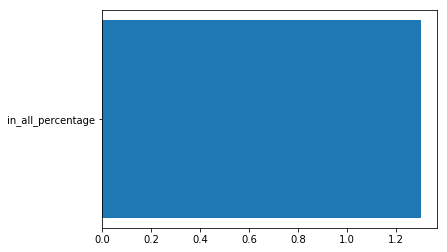

In [389]:
best_f, auc_score, min_cv_score, test_acc = find_best_feature(X_flourishing, y_flourishing)

In [390]:
best_f, auc_score, min_cv_score, test_acc

('dark_var', 0.5555555555555556, 0.6666666666666666, 0.38461538461538464)

Train accuracy: 0.7333333333333333
Test accuracy: 0.38461538461538464
cv accuracies: [0.55555556 0.85714286 0.71428571 0.71428571]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

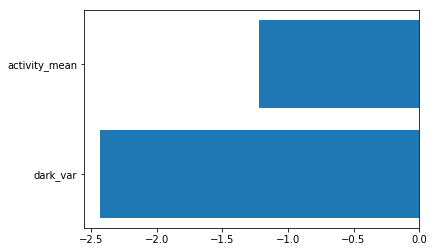

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

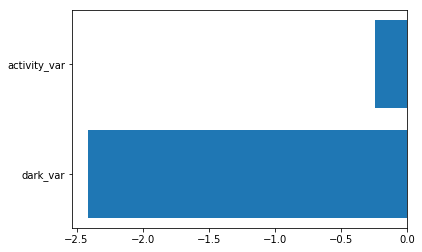

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.71428571 0.71428571 0.85714286]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

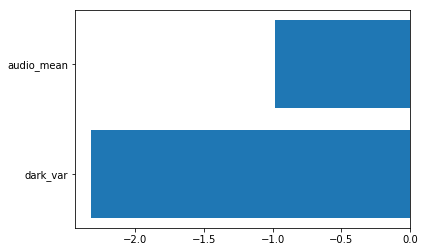

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.77777778 0.57142857 0.85714286 0.85714286]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.30      0.75      0.43         4
           1       0.67      0.22      0.33         9

    accuracy                           0.38        13
   macro avg       0.48      0.49      0.38        13
weighted avg       0.55      0.38      0.36        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.49	21.25	0.38	0.33	0.67	0.22	

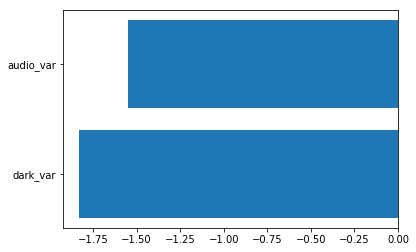

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.55555556 0.71428571 0.71428571 0.71428571]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

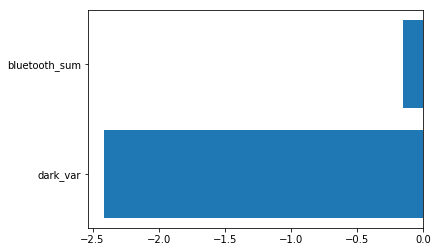

Train accuracy: 0.8
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.71428571 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

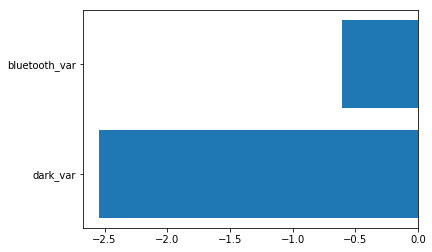

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.44444444 0.71428571 0.71428571 0.71428571]
min cv acc: 0.4444444444444444
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

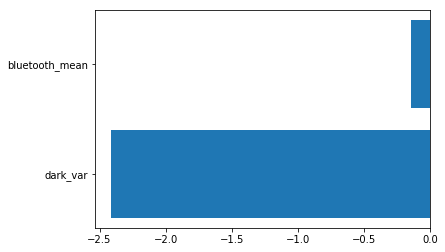

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

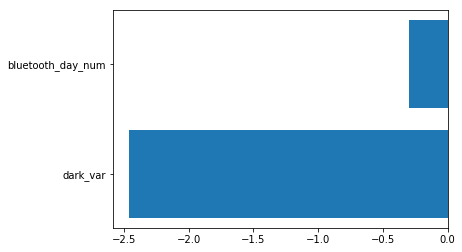

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.71428571 0.85714286]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

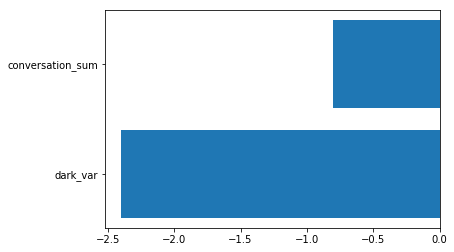

Train accuracy: 0.8
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.71428571 0.85714286 0.85714286]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

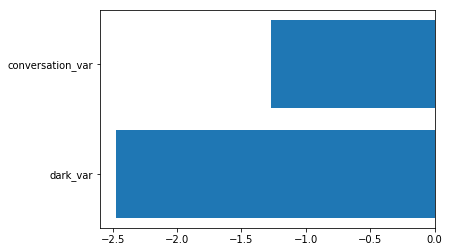

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.71428571 0.71428571 0.85714286]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

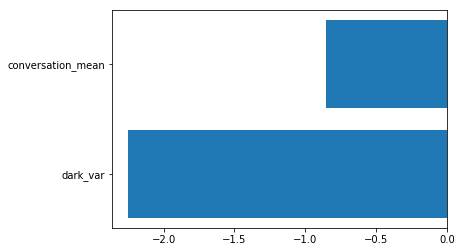

Train accuracy: 0.8
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.57142857 0.71428571]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

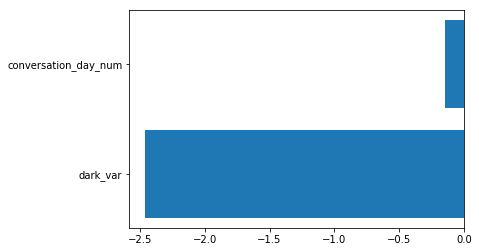

Train accuracy: 0.8
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

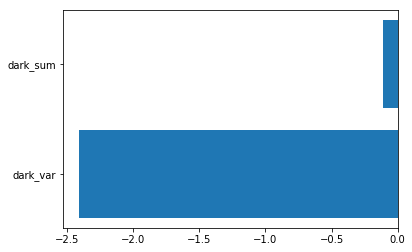

Train accuracy: 0.8
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

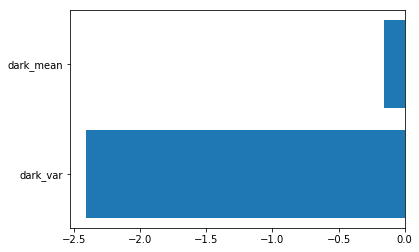

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.71428571 0.57142857 0.71428571]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

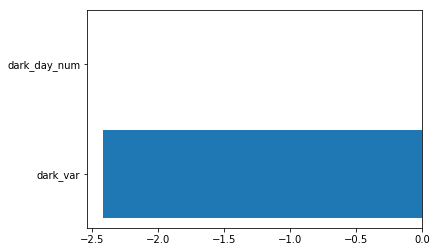

Train accuracy: 0.7333333333333333
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.71428571 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

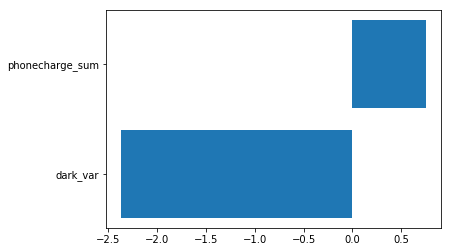

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

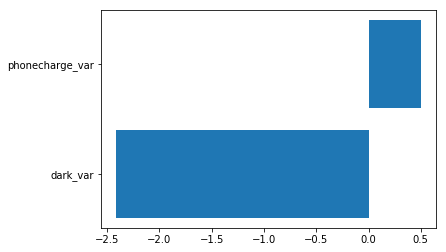

Train accuracy: 0.7
Test accuracy: 0.38461538461538464
cv accuracies: [0.77777778 0.71428571 0.71428571 0.71428571]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

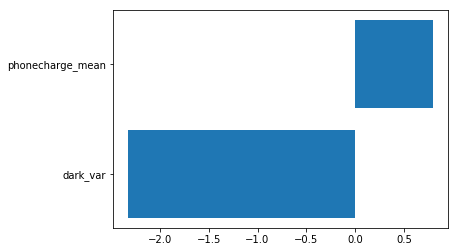

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.71428571 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

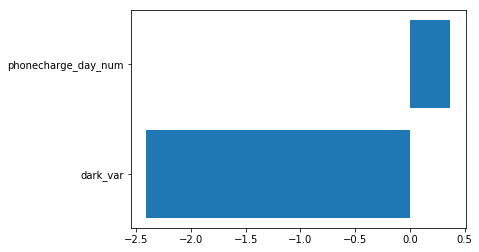

Train accuracy: 0.7333333333333333
Test accuracy: 0.46153846153846156
cv accuracies: [0.66666667 0.71428571 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

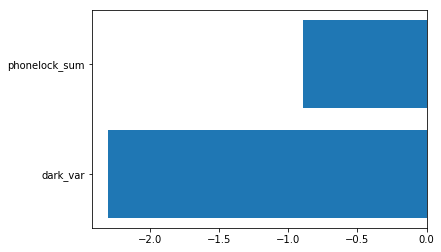

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.88888889 0.42857143 0.71428571 0.85714286]
min cv acc: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

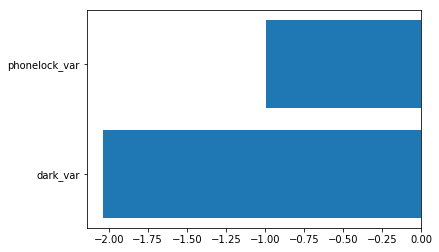

Train accuracy: 0.7666666666666667
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.71428571 0.71428571 0.71428571]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

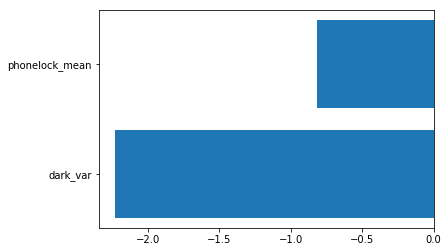

Train accuracy: 0.7333333333333333
Test accuracy: 0.46153846153846156
cv accuracies: [0.66666667 0.71428571 0.57142857 0.71428571]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

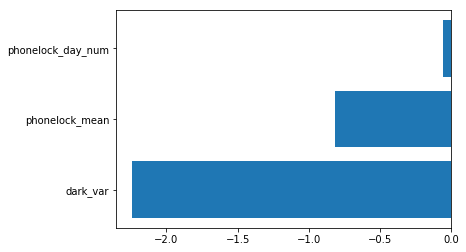

Train accuracy: 0.7333333333333333
Test accuracy: 0.46153846153846156
cv accuracies: [0.66666667 0.71428571 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

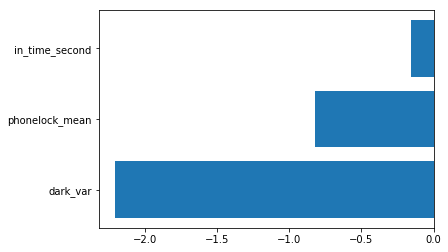

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.57142857 0.57142857]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.30      0.75      0.43         4
           1       0.67      0.22      0.33         9

    accuracy                           0.38        13
   macro avg       0.48      0.49      0.38        13
weighted avg       0.55      0.38      0.36        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.49	21.25	0.38	0.33	0.67	0.22	

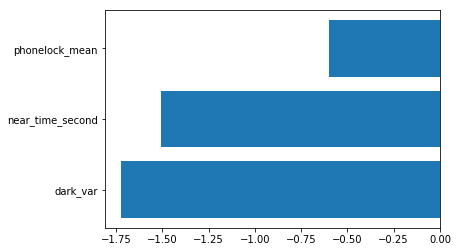

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.57142857 0.57142857]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.30      0.75      0.43         4
           1       0.67      0.22      0.33         9

    accuracy                           0.38        13
   macro avg       0.48      0.49      0.38        13
weighted avg       0.55      0.38      0.36        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.49	21.25	0.38	0.33	0.67	0.22	

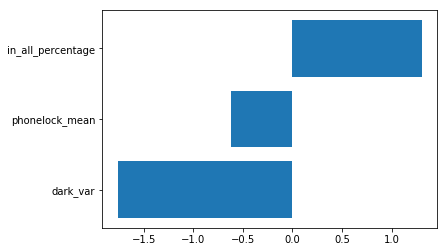

In [391]:
curr_cols, auc_score, min_cv_score, test_acc = feature_selector(X_flourishing, y_flourishing, [best_f], 
                 auc_score, min_cv_score, test_acc)

In [392]:
curr_cols, auc_score, min_cv_score, test_acc

(['dark_var', 'phonelock_mean'],
 0.6111111111111112,
 0.7142857142857143,
 0.46153846153846156)

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.55555556 0.85714286 0.71428571 0.71428571]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

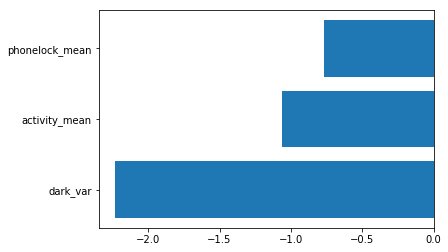

Train accuracy: 0.7333333333333333
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.71428571 0.71428571 0.71428571]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

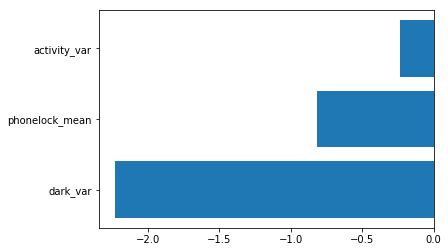

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.55555556 0.71428571 0.71428571 0.85714286]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

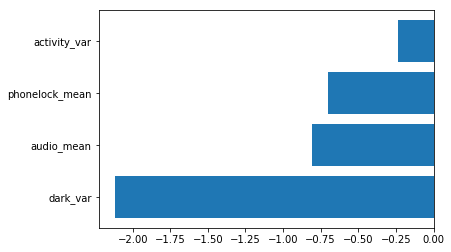

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.77777778 0.57142857 0.71428571 0.85714286]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.30      0.75      0.43         4
           1       0.67      0.22      0.33         9

    accuracy                           0.38        13
   macro avg       0.48      0.49      0.38        13
weighted avg       0.55      0.38      0.36        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.49	21.25	0.38	0.33	0.67	0.22	

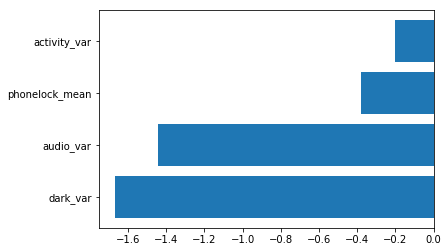

Train accuracy: 0.7333333333333333
Test accuracy: 0.46153846153846156
cv accuracies: [0.66666667 0.71428571 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

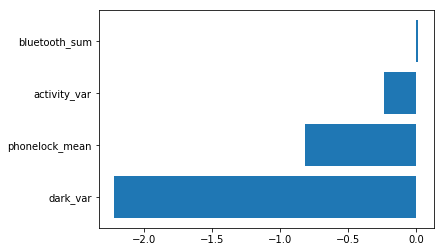

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.88888889 0.71428571 0.71428571 0.85714286]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

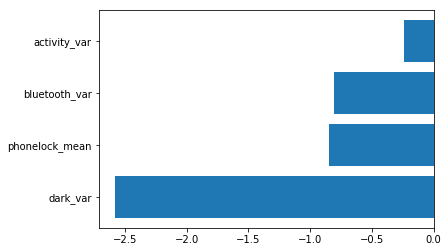

Train accuracy: 0.7
Test accuracy: 0.46153846153846156
cv accuracies: [0.66666667 0.71428571 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

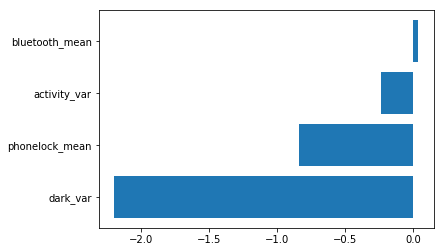

Train accuracy: 0.7333333333333333
Test accuracy: 0.5384615384615384
cv accuracies: [0.66666667 0.71428571 0.57142857 0.71428571]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         4
           1       1.00      0.33      0.50         9

    accuracy                           0.54        13
   macro avg       0.70      0.67      0.54        13
weighted avg       0.82      0.54      0.52        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.67	15.94	0.54	0.50	1.00	0.33	

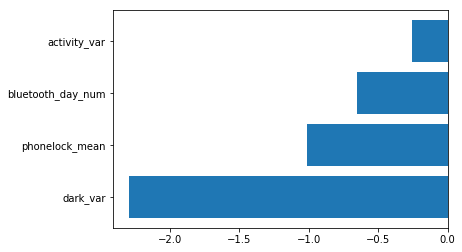

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.44444444 0.85714286 0.71428571 0.85714286]
min cv acc: 0.4444444444444444
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

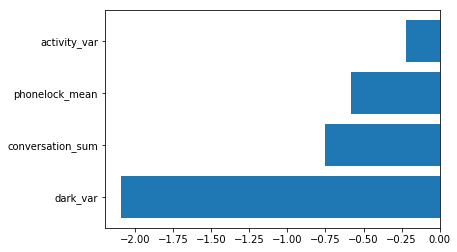

Train accuracy: 0.8333333333333334
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.85714286 0.71428571 0.85714286]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

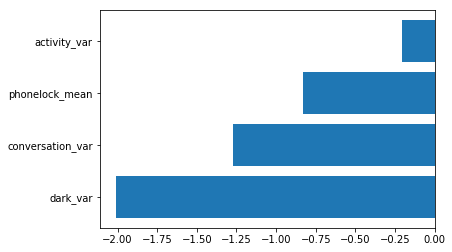

Train accuracy: 0.8
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.85714286 0.71428571 0.85714286]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

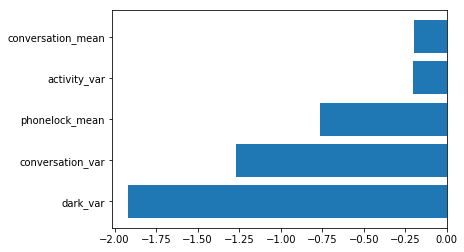

Train accuracy: 0.8
Test accuracy: 0.46153846153846156
cv accuracies: [0.66666667 0.85714286 0.71428571 0.85714286]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

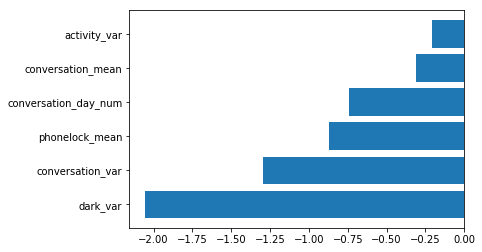

Train accuracy: 0.8
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.71428571 0.71428571 0.85714286]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

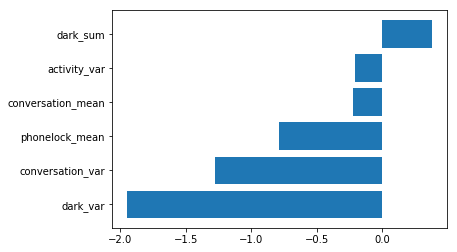

Train accuracy: 0.8
Test accuracy: 0.46153846153846156
cv accuracies: [0.66666667 0.71428571 0.71428571 0.85714286]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

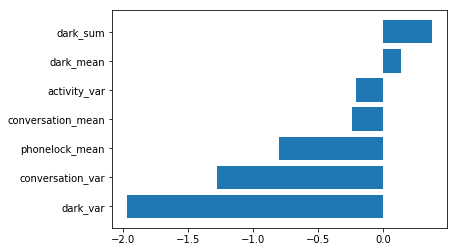

Train accuracy: 0.7666666666666667
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.71428571 0.71428571 0.71428571]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

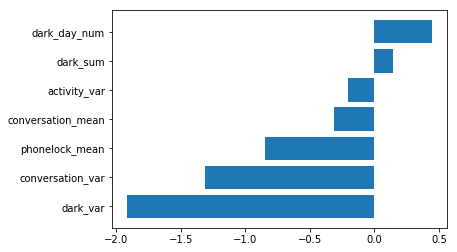

Train accuracy: 0.8
Test accuracy: 0.46153846153846156
cv accuracies: [0.55555556 0.71428571 0.71428571 0.71428571]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

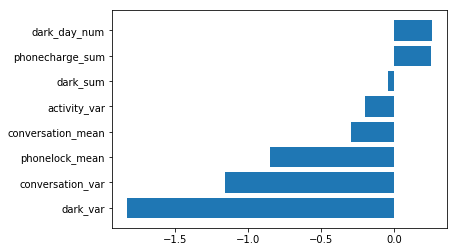

Train accuracy: 0.7666666666666667
Test accuracy: 0.46153846153846156
cv accuracies: [0.55555556 0.85714286 0.71428571 0.71428571]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

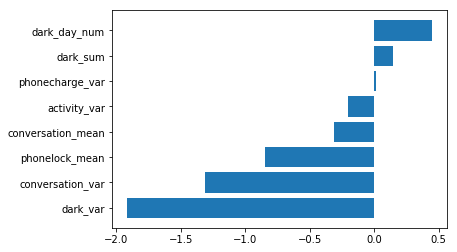

Train accuracy: 0.8
Test accuracy: 0.46153846153846156
cv accuracies: [0.55555556 0.71428571 0.71428571 0.71428571]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

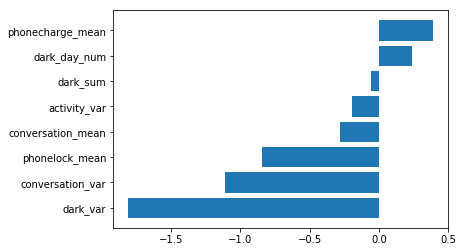

Train accuracy: 0.7666666666666667
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.71428571 0.71428571 0.71428571]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

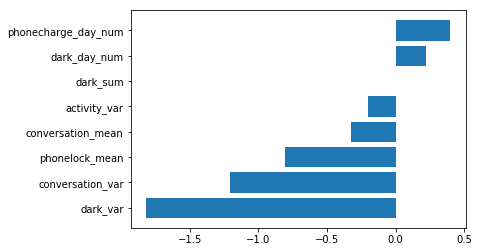

Train accuracy: 0.7666666666666667
Test accuracy: 0.46153846153846156
cv accuracies: [0.55555556 0.71428571 0.71428571 0.71428571]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

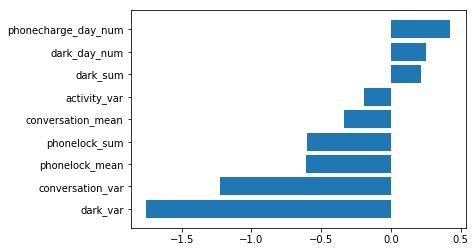

Train accuracy: 0.8
Test accuracy: 0.46153846153846156
cv accuracies: [0.66666667 0.57142857 0.71428571 0.71428571]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

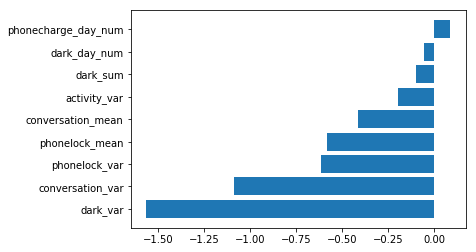

Train accuracy: 0.7666666666666667
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.71428571 0.71428571 0.57142857]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

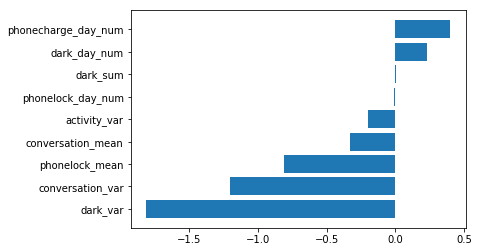

Train accuracy: 0.8
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.57142857 0.71428571 0.71428571]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

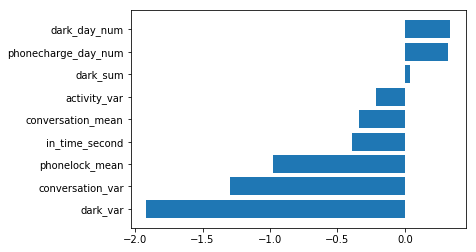

Train accuracy: 0.8333333333333334
Test accuracy: 0.46153846153846156
cv accuracies: [0.66666667 0.71428571 0.71428571 0.57142857]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.33      0.75      0.46         4
           1       0.75      0.33      0.46         9

    accuracy                           0.46        13
   macro avg       0.54      0.54      0.46        13
weighted avg       0.62      0.46      0.46        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.54	18.60	0.46	0.46	0.75	0.33	

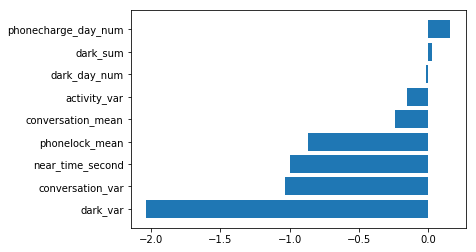

Train accuracy: 0.8
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.71428571 0.71428571 0.57142857]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.30      0.75      0.43         4
           1       0.67      0.22      0.33         9

    accuracy                           0.38        13
   macro avg       0.48      0.49      0.38        13
weighted avg       0.55      0.38      0.36        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.49	21.25	0.38	0.33	0.67	0.22	

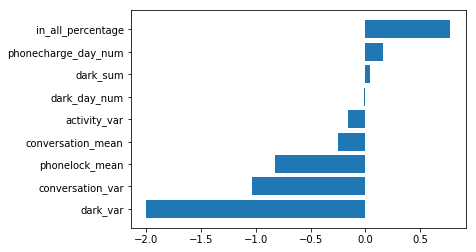

In [394]:
curr_cols, auc_score, min_cv_score, test_acc = feature_selector_equal(X_flourishing, y_flourishing, curr_cols, 
                 auc_score, min_cv_score, test_acc)

In [395]:
curr_cols, auc_score, min_cv_score, test_acc

(['dark_var',
  'phonelock_mean',
  'activity_var',
  'conversation_var',
  'conversation_mean',
  'dark_sum',
  'dark_day_num',
  'phonecharge_day_num'],
 0.6111111111111112,
 0.7142857142857143,
 0.46153846153846156)

Train accuracy: 0.7666666666666667
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.71428571 0.71428571 0.71428571]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

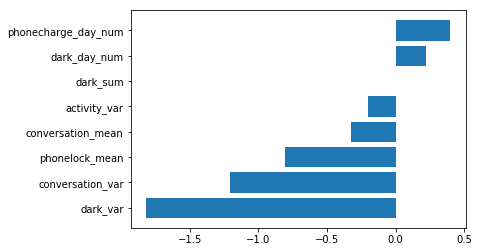

In [386]:
# best feature selection
X1 = X_flourishing[['dark_var', 'phonelock_mean', 'activity_var', 
                    'conversation_var', 'conversation_mean', 
                    'dark_sum', 'dark_day_num', 'phonecharge_day_num']]
auc_score, min_cv_score, test_acc = pred_post_svc(X1, y_flourishing)


In [396]:
def param_tuning(X, y, params):
    
    X_train = X.iloc[:30,:]
    X_test = X.iloc[30:,:]
    y_train = y[:30]
    y_test = y[30:]
    
    # kernel If none is given, ‘rbf’ will be used. kernel = 'linear',
    svc = SVC()
    classifier = GridSearchCV(svc, params, cv=4)
    classifier.fit(X_train, y_train)
    for key, value in classifier.cv_results_.items():
        print(key, ': ', value)
    
    train_pred = classifier.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    print('Train accuracy:', train_acc)

    test_pred = classifier.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print('Test accuracy:', test_acc)
    
    # X_train 4 fold
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=4)
    print('cv accuracies:', cv_scores)
    print('min cv acc:', min(cv_scores))
    
    # f1, recall, precision
    print(classification_report(y_test, test_pred))
    
    # all metrics
    auc_score = evaluation_metrics(y_test, test_pred)
    
    # plot feature importance
    #feature_names = X.columns
    #feature_importances(classifier.coef_[0], feature_names)
    
    return auc_score, min(cv_scores), test_acc

In [398]:
params = {'C': [1, 10, 100, 1000], 'kernel': ['linear']}
param_tuning(X1, y_flourishing, params)

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages

mean_fit_time :  [0.00238878 0.00185722 0.00252444 0.00286323]
std_fit_time :  [0.00049044 0.00013317 0.00081825 0.00052468]
mean_score_time :  [0.00145578 0.00086808 0.00133133 0.00182754]
std_score_time :  [0.00052463 0.00011571 0.00032808 0.00135785]
param_C :  [1 10 100 1000]
param_kernel :  ['linear' 'linear' 'linear' 'linear']
params :  [{'C': 1, 'kernel': 'linear'}, {'C': 10, 'kernel': 'linear'}, {'C': 100, 'kernel': 'linear'}, {'C': 1000, 'kernel': 'linear'}]
split0_test_score :  [0.77777778 0.77777778 0.66666667 0.66666667]
split1_test_score :  [0.71428571 0.71428571 0.28571429 0.85714286]
split2_test_score :  [0.71428571 0.71428571 0.71428571 0.85714286]
split3_test_score :  [0.71428571 0.57142857 0.57142857 0.57142857]
mean_test_score :  [0.73333333 0.7        0.56666667 0.73333333]
std_test_score :  [0.02909572 0.07594206 0.16281258 0.1208436 ]
rank_test_score :  [1 3 4 1]
Train accuracy: 0.7666666666666667
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.714

(0.6111111111111112, 0.5714285714285714, 0.46153846153846156)

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

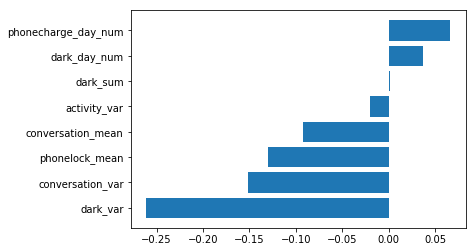

Train accuracy: 0.7666666666666667
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.71428571 0.71428571 0.71428571]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

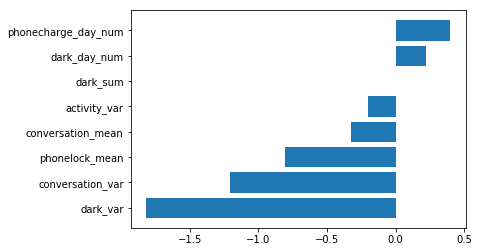

Train accuracy: 0.8
Test accuracy: 0.38461538461538464
cv accuracies: [0.77777778 0.71428571 0.71428571 0.57142857]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

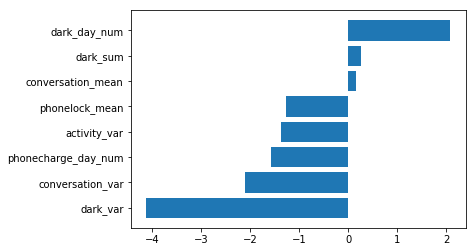

Train accuracy: 0.8333333333333334
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.28571429 0.71428571 0.57142857]
min cv acc: 0.2857142857142857
              precision    recall  f1-score   support

           0       0.30      0.75      0.43         4
           1       0.67      0.22      0.33         9

    accuracy                           0.38        13
   macro avg       0.48      0.49      0.38        13
weighted avg       0.55      0.38      0.36        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.49	21.25	0.38	0.33	0.67	0.22	

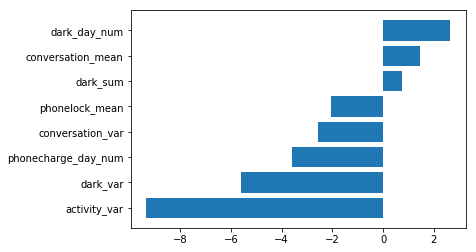

Train accuracy: 0.9333333333333333
Test accuracy: 0.5384615384615384
cv accuracies: [0.66666667 0.85714286 0.85714286 0.57142857]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.71      0.56      0.63         9

    accuracy                           0.54        13
   macro avg       0.52      0.53      0.51        13
weighted avg       0.60      0.54      0.56        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.53	15.94	0.54	0.63	0.71	0.56	

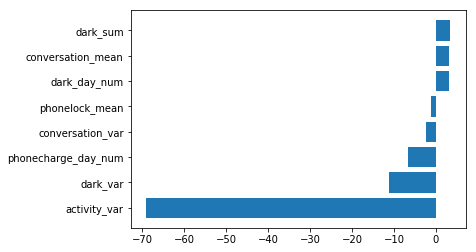

In [401]:
# tune penalty parameter C
cs = [0.1, 1, 10, 100, 1000]
for c in cs:
    pred_post_svc(X1, y_flourishing, c)

Train accuracy: 0.7666666666666667
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.71428571 0.71428571 0.71428571]
min cv acc: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

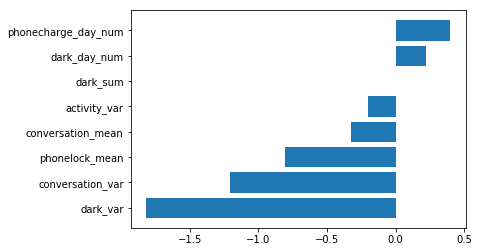

Train accuracy: 0.7333333333333333
Test accuracy: 0.46153846153846156
cv accuracies: [0.77777778 0.57142857 0.71428571 0.71428571]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       1.00      0.22      0.36         9

    accuracy                           0.46        13
   macro avg       0.68      0.61      0.45        13
weighted avg       0.80      0.46      0.42        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.61	18.60	0.46	0.36	1.00	0.22	

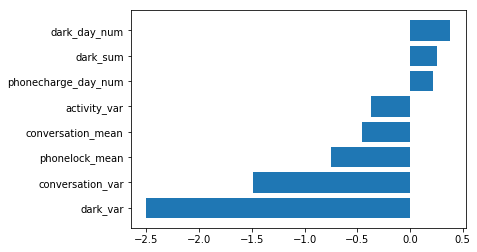

Train accuracy: 0.7666666666666667
Test accuracy: 0.5384615384615384
cv accuracies: [0.77777778 0.57142857 0.71428571 0.57142857]
min cv acc: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         4
           1       1.00      0.33      0.50         9

    accuracy                           0.54        13
   macro avg       0.70      0.67      0.54        13
weighted avg       0.82      0.54      0.52        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.67	15.94	0.54	0.50	1.00	0.33	

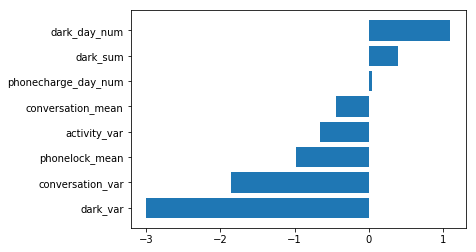

In [402]:
# tune penalty parameter C
cs = [ 1, 2, 4]
for c in cs:
    pred_post_svc(X1, y_flourishing, c)

### PANAS postive

Train accuracy: 0.7333333333333333
Test accuracy: 0.5
cv accuracies: [0.75       0.75       0.5        0.83333333]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.57      0.50      0.53         8

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.51      0.50      0.50        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	17.27	0.50	0.53	0.57	0.50	

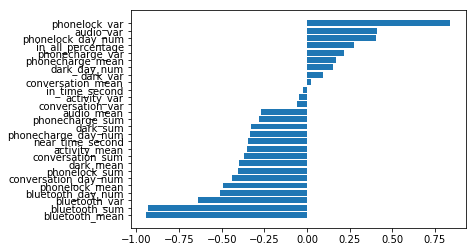

In [281]:
auc_score, min_cv_score, test_acc = pred_post_svc(X_panas, y_panas_pos)

Train accuracy: 0.6
Test accuracy: 0.5
cv accuracies: [0.625      0.5        0.625      0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.44      0.67      0.53         6
           1       0.60      0.38      0.46         8

    accuracy                           0.50        14
   macro avg       0.52      0.52      0.50        14
weighted avg       0.53      0.50      0.49        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.52	17.27	0.50	0.46	0.60	0.38	

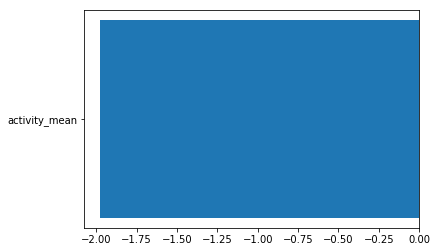

Train accuracy: 0.6
Test accuracy: 0.42857142857142855
cv accuracies: [0.75       0.5        0.5        0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.38      0.50      0.43         6
           1       0.50      0.38      0.43         8

    accuracy                           0.43        14
   macro avg       0.44      0.44      0.43        14
weighted avg       0.45      0.43      0.43        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.44	19.74	0.43	0.43	0.50	0.38	

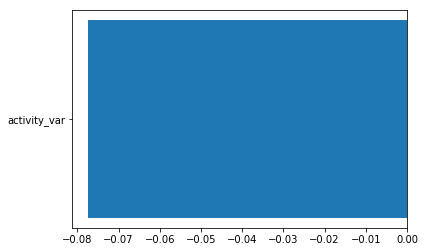

Train accuracy: 0.6333333333333333
Test accuracy: 0.5
cv accuracies: [0.625 0.75  0.5   0.5  ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.45      0.83      0.59         6
           1       0.67      0.25      0.36         8

    accuracy                           0.50        14
   macro avg       0.56      0.54      0.48        14
weighted avg       0.58      0.50      0.46        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.54	17.27	0.50	0.36	0.67	0.25	

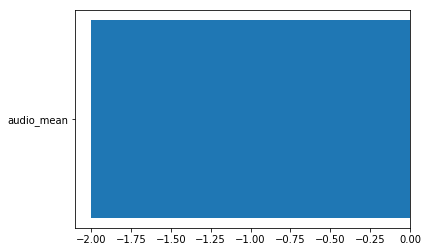

Train accuracy: 0.5333333333333333
Test accuracy: 0.7857142857142857
cv accuracies: [0.25       0.5        0.5        0.33333333]
min cv acc: 0.25
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.73      1.00      0.84         8

    accuracy                           0.79        14
   macro avg       0.86      0.75      0.75        14
weighted avg       0.84      0.79      0.77        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.75	7.40	0.79	0.84	0.73	1.00	

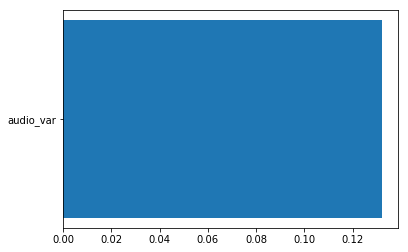

Train accuracy: 0.7333333333333333
Test accuracy: 0.5
cv accuracies: [0.625      0.625      0.75       0.66666667]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.45      0.83      0.59         6
           1       0.67      0.25      0.36         8

    accuracy                           0.50        14
   macro avg       0.56      0.54      0.48        14
weighted avg       0.58      0.50      0.46        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.54	17.27	0.50	0.36	0.67	0.25	

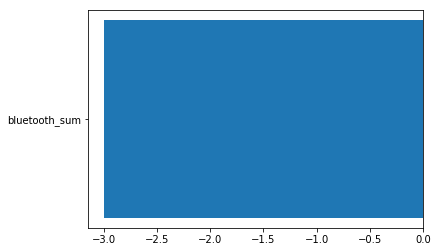

Train accuracy: 0.5666666666666667
Test accuracy: 0.35714285714285715
cv accuracies: [0.5        0.625      0.5        0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.36      0.67      0.47         6
           1       0.33      0.12      0.18         8

    accuracy                           0.36        14
   macro avg       0.35      0.40      0.33        14
weighted avg       0.35      0.36      0.31        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.40	22.20	0.36	0.18	0.33	0.12	

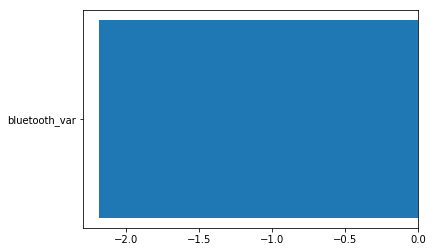

Train accuracy: 0.7666666666666667
Test accuracy: 0.5
cv accuracies: [0.75       0.625      0.75       0.66666667]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.45      0.83      0.59         6
           1       0.67      0.25      0.36         8

    accuracy                           0.50        14
   macro avg       0.56      0.54      0.48        14
weighted avg       0.58      0.50      0.46        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.54	17.27	0.50	0.36	0.67	0.25	

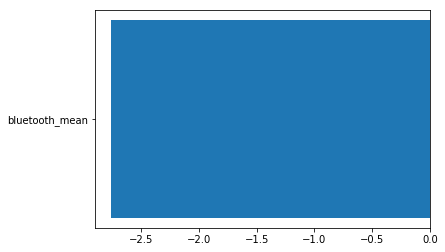

Train accuracy: 0.6666666666666666
Test accuracy: 0.7142857142857143
cv accuracies: [0.75       0.625      0.5        0.83333333]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.70      0.88      0.78         8

    accuracy                           0.71        14
   macro avg       0.72      0.69      0.69        14
weighted avg       0.72      0.71      0.70        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.69	9.87	0.71	0.78	0.70	0.88	

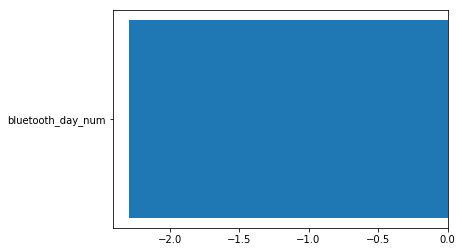

Train accuracy: 0.7666666666666667
Test accuracy: 0.5714285714285714
cv accuracies: [0.75       0.875      0.625      0.66666667]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.50      0.83      0.62         6
           1       0.75      0.38      0.50         8

    accuracy                           0.57        14
   macro avg       0.62      0.60      0.56        14
weighted avg       0.64      0.57      0.55        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.60	14.80	0.57	0.50	0.75	0.38	

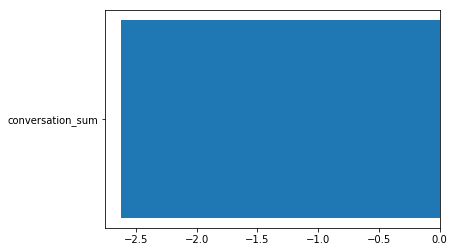

Train accuracy: 0.5666666666666667
Test accuracy: 0.35714285714285715
cv accuracies: [0.375      0.625      0.375      0.66666667]
min cv acc: 0.375
              precision    recall  f1-score   support

           0       0.36      0.67      0.47         6
           1       0.33      0.12      0.18         8

    accuracy                           0.36        14
   macro avg       0.35      0.40      0.33        14
weighted avg       0.35      0.36      0.31        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.40	22.20	0.36	0.18	0.33	0.12	

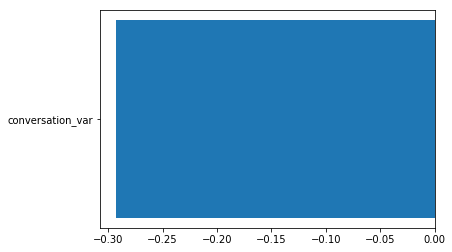

Train accuracy: 0.6
Test accuracy: 0.5
cv accuracies: [0.75       0.75       0.5        0.33333333]
min cv acc: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.44      0.67      0.53         6
           1       0.60      0.38      0.46         8

    accuracy                           0.50        14
   macro avg       0.52      0.52      0.50        14
weighted avg       0.53      0.50      0.49        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.52	17.27	0.50	0.46	0.60	0.38	

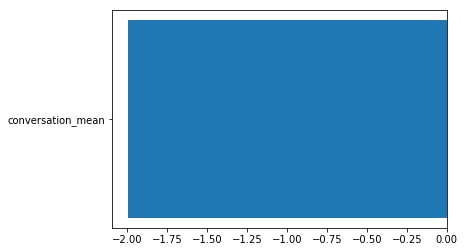

Train accuracy: 0.7
Test accuracy: 0.7857142857142857
cv accuracies: [0.75       0.625      0.625      0.66666667]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.78      0.88      0.82         8

    accuracy                           0.79        14
   macro avg       0.79      0.77      0.78        14
weighted avg       0.79      0.79      0.78        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.77	7.40	0.79	0.82	0.78	0.88	

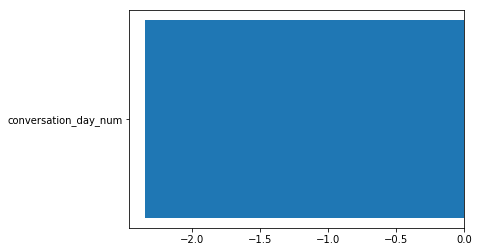

Train accuracy: 0.6666666666666666
Test accuracy: 0.2857142857142857
cv accuracies: [0.5        0.875      0.5        0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.30      0.50      0.37         6
           1       0.25      0.12      0.17         8

    accuracy                           0.29        14
   macro avg       0.28      0.31      0.27        14
weighted avg       0.27      0.29      0.26        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.31	24.67	0.29	0.17	0.25	0.12	

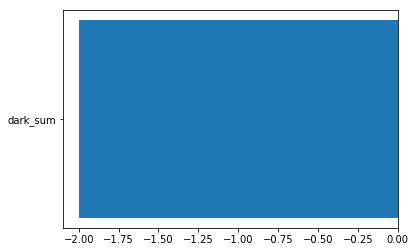

Train accuracy: 0.5333333333333333
Test accuracy: 0.5
cv accuracies: [0.375 0.375 0.625 0.5  ]
min cv acc: 0.375
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.54      0.88      0.67         8

    accuracy                           0.50        14
   macro avg       0.27      0.44      0.33        14
weighted avg       0.31      0.50      0.38        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.44	17.27	0.50	0.67	0.54	0.88	

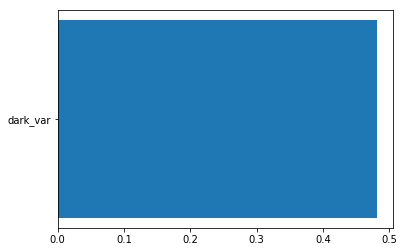

Train accuracy: 0.6
Test accuracy: 0.42857142857142855
cv accuracies: [0.625 0.625 0.75  0.5  ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.42      0.83      0.56         6
           1       0.50      0.12      0.20         8

    accuracy                           0.43        14
   macro avg       0.46      0.48      0.38        14
weighted avg       0.46      0.43      0.35        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.48	19.74	0.43	0.20	0.50	0.12	

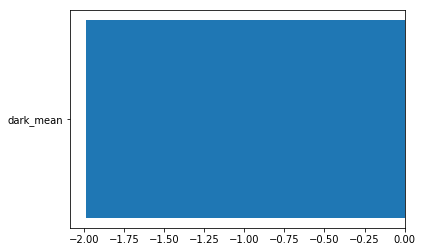

Train accuracy: 0.6
Test accuracy: 0.5
cv accuracies: [0.625      0.625      0.5        0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.57      0.50      0.53         8

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.51      0.50      0.50        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	17.27	0.50	0.53	0.57	0.50	

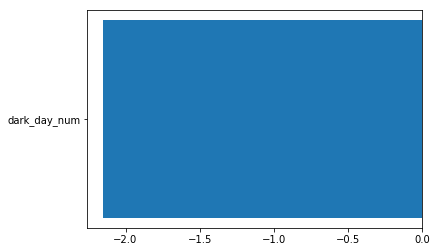

Train accuracy: 0.5
Test accuracy: 0.5714285714285714
cv accuracies: [0.5 0.5 0.5 0.5]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         6
           1       1.00      0.25      0.40         8

    accuracy                           0.57        14
   macro avg       0.75      0.62      0.53        14
weighted avg       0.79      0.57      0.51        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.62	14.80	0.57	0.40	1.00	0.25	

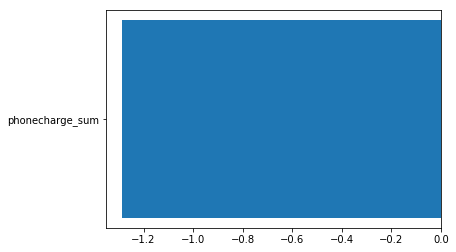

Train accuracy: 0.5333333333333333
Test accuracy: 0.7142857142857143
cv accuracies: [0.375 0.75  0.5   0.5  ]
min cv acc: 0.375
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.67      1.00      0.80         8

    accuracy                           0.71        14
   macro avg       0.83      0.67      0.65        14
weighted avg       0.81      0.71      0.67        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.67	9.87	0.71	0.80	0.67	1.00	

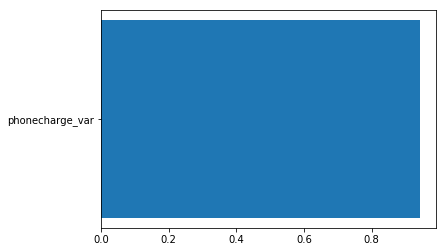

Train accuracy: 0.6
Test accuracy: 0.5714285714285714
cv accuracies: [0.375 0.375 0.625 0.5  ]
min cv acc: 0.375
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.60      0.75      0.67         8

    accuracy                           0.57        14
   macro avg       0.55      0.54      0.53        14
weighted avg       0.56      0.57      0.55        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.54	14.80	0.57	0.67	0.60	0.75	

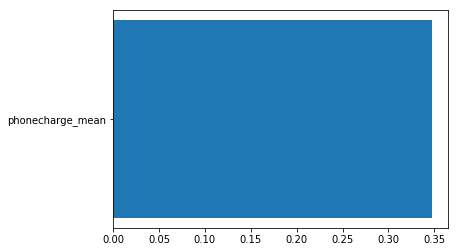

Train accuracy: 0.7333333333333333
Test accuracy: 0.5
cv accuracies: [0.875      0.75       0.625      0.66666667]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.57      0.50      0.53         8

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.51      0.50      0.50        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	17.27	0.50	0.53	0.57	0.50	

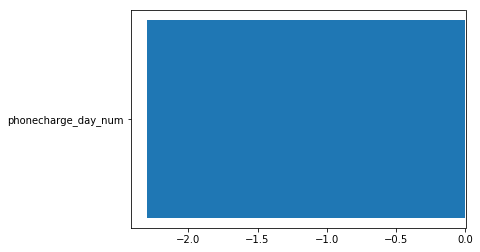

Train accuracy: 0.7333333333333333
Test accuracy: 0.42857142857142855
cv accuracies: [0.625      0.75       0.75       0.83333333]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.38      0.50      0.43         6
           1       0.50      0.38      0.43         8

    accuracy                           0.43        14
   macro avg       0.44      0.44      0.43        14
weighted avg       0.45      0.43      0.43        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.44	19.74	0.43	0.43	0.50	0.38	

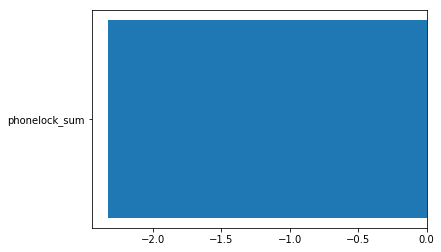

Train accuracy: 0.5666666666666667
Test accuracy: 0.5714285714285714
cv accuracies: [0.75       0.5        0.5        0.33333333]
min cv acc: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.67      0.50      0.57         8

    accuracy                           0.57        14
   macro avg       0.58      0.58      0.57        14
weighted avg       0.60      0.57      0.57        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.58	14.80	0.57	0.57	0.67	0.50	

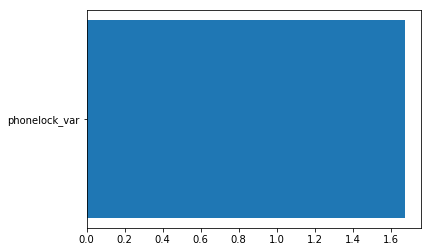

Train accuracy: 0.6333333333333333
Test accuracy: 0.42857142857142855
cv accuracies: [0.625      0.625      0.625      0.83333333]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         6
           1       0.50      0.50      0.50         8

    accuracy                           0.43        14
   macro avg       0.42      0.42      0.42        14
weighted avg       0.43      0.43      0.43        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.42	19.74	0.43	0.50	0.50	0.50	

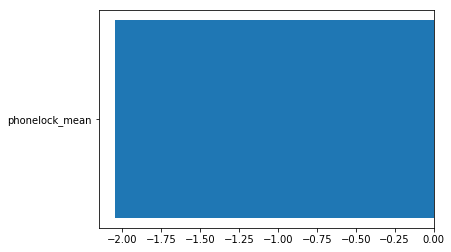

Train accuracy: 0.5666666666666667
Test accuracy: 0.7142857142857143
cv accuracies: [0.625      0.625      0.5        0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.70      0.88      0.78         8

    accuracy                           0.71        14
   macro avg       0.72      0.69      0.69        14
weighted avg       0.72      0.71      0.70        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.69	9.87	0.71	0.78	0.70	0.88	

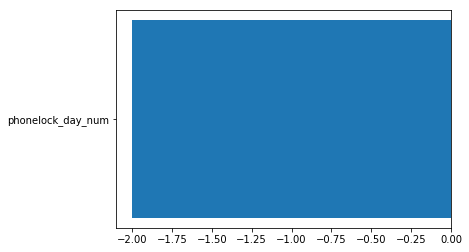

Train accuracy: 0.6
Test accuracy: 0.5
cv accuracies: [0.625      0.5        0.625      0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.54      0.88      0.67         8

    accuracy                           0.50        14
   macro avg       0.27      0.44      0.33        14
weighted avg       0.31      0.50      0.38        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.44	17.27	0.50	0.67	0.54	0.88	

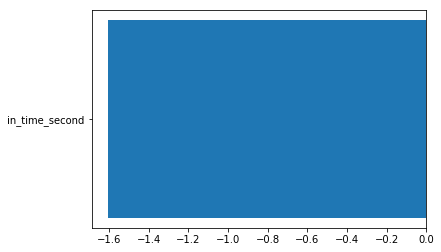

Train accuracy: 0.5
Test accuracy: 0.42857142857142855
cv accuracies: [0.625 0.5   0.5   0.5  ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         6
           1       0.50      0.25      0.33         8

    accuracy                           0.43        14
   macro avg       0.45      0.46      0.42        14
weighted avg       0.46      0.43      0.40        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.46	19.74	0.43	0.33	0.50	0.25	

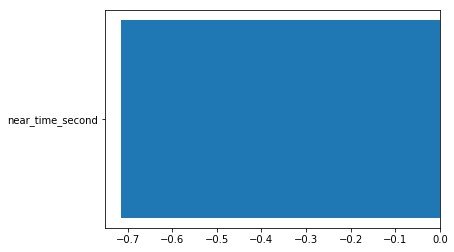

Train accuracy: 0.5333333333333333
Test accuracy: 0.42857142857142855
cv accuracies: [0.625 0.5   0.5   0.5  ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         6
           1       0.50      0.25      0.33         8

    accuracy                           0.43        14
   macro avg       0.45      0.46      0.42        14
weighted avg       0.46      0.43      0.40        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.46	19.74	0.43	0.33	0.50	0.25	

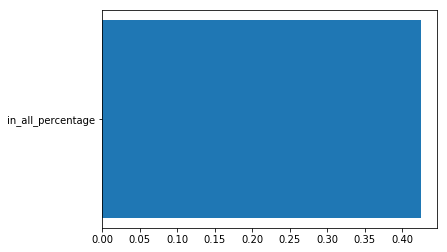

In [404]:
best_f, auc_score, min_cv_score, test_acc = find_best_feature(X_panas, y_panas_pos)
    

In [405]:
best_f, auc_score, min_cv_score, test_acc 

('conversation_sum', 0.6041666666666667, 0.625, 0.5714285714285714)

Train accuracy: 0.7666666666666667
Test accuracy: 0.5714285714285714
cv accuracies: [0.75       0.875      0.625      0.66666667]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.50      0.83      0.62         6
           1       0.75      0.38      0.50         8

    accuracy                           0.57        14
   macro avg       0.62      0.60      0.56        14
weighted avg       0.64      0.57      0.55        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.60	14.80	0.57	0.50	0.75	0.38	

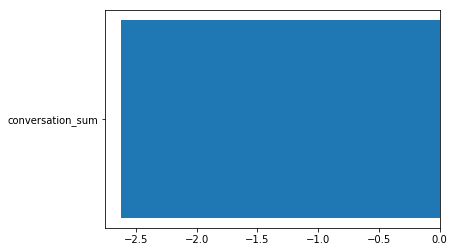

(0.6041666666666667, 0.625, 0.5714285714285714)

In [406]:
pred_post_svc(X_panas[[best_f]], y_panas_pos)

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.44444444 0.57142857 0.57142857 0.57142857]
min cv acc: 0.4444444444444444
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

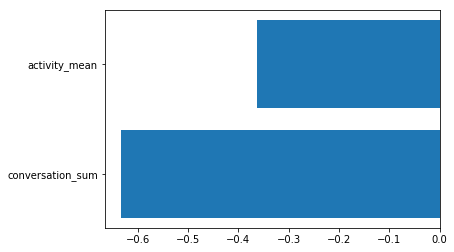

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

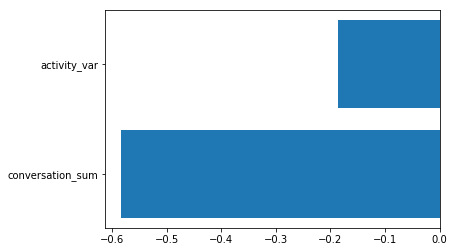

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

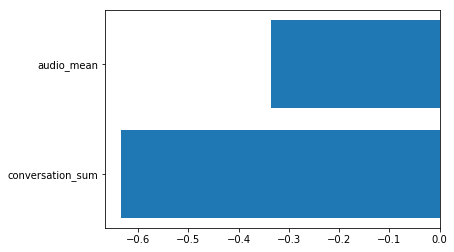

Train accuracy: 0.7
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.71428571 0.71428571]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.27      0.75      0.40         4
           1       0.50      0.11      0.18         9

    accuracy                           0.31        13
   macro avg       0.39      0.43      0.29        13
weighted avg       0.43      0.31      0.25        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.43	23.91	0.31	0.18	0.50	0.11	

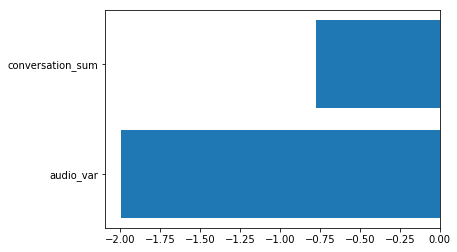

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

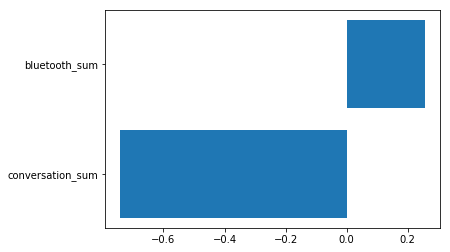

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

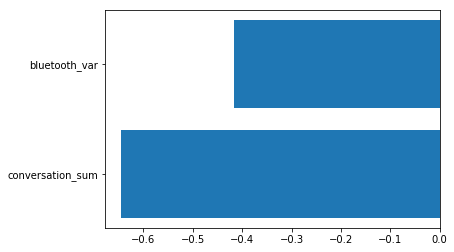

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

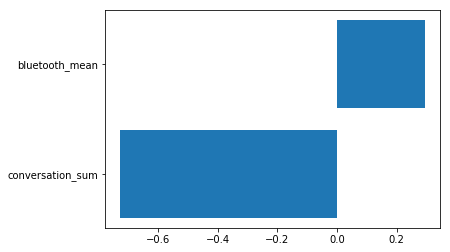

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

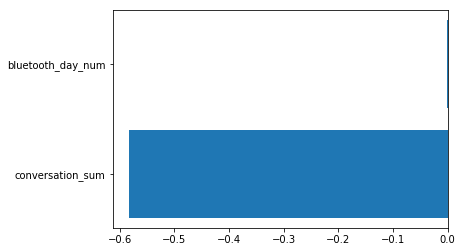

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

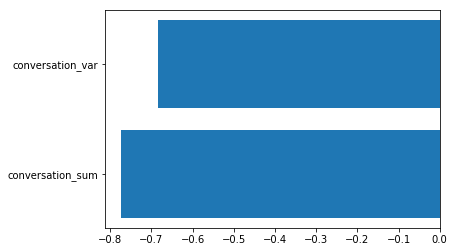

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

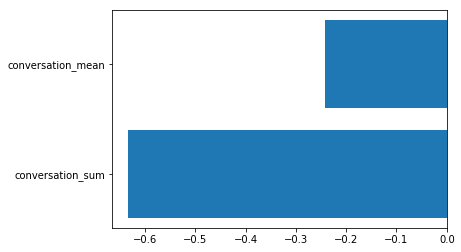

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

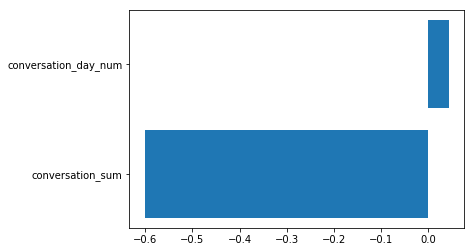

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

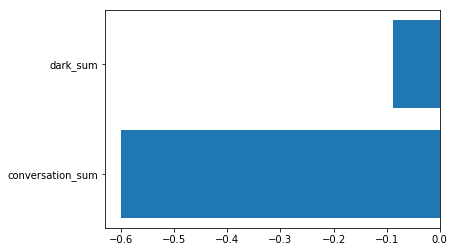

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.71428571 0.85714286]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

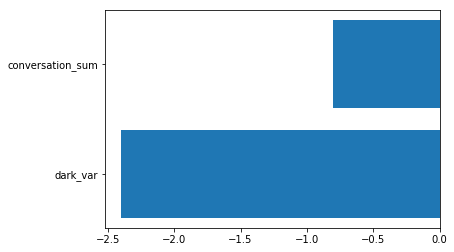

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

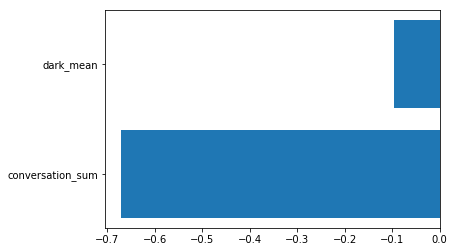

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

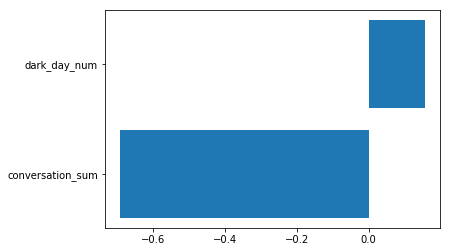

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

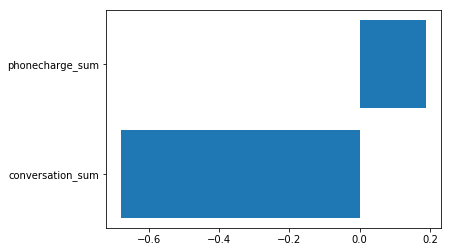

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

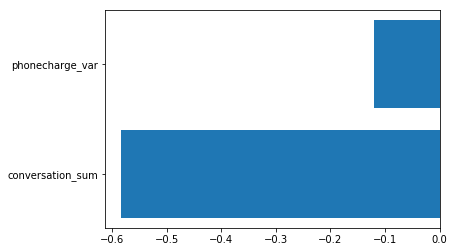

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

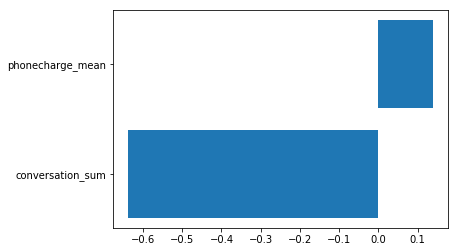

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

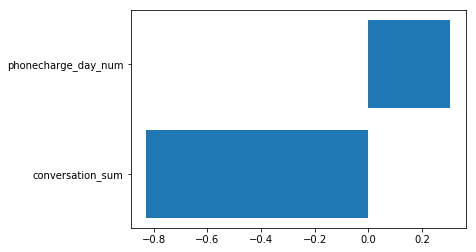

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

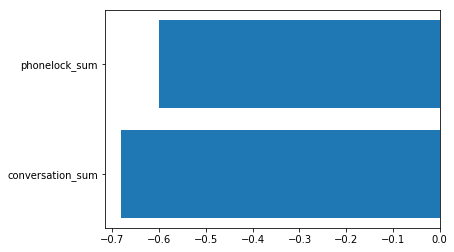

Train accuracy: 0.7
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.71428571 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

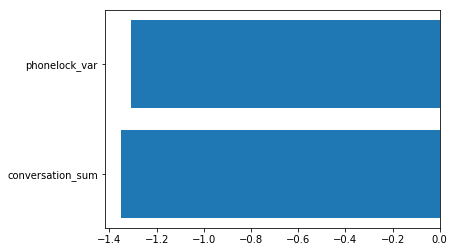

Train accuracy: 0.5333333333333333
Test accuracy: 0.3076923076923077
cv accuracies: [0.44444444 0.57142857 0.71428571 0.57142857]
min cv acc: 0.4444444444444444
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

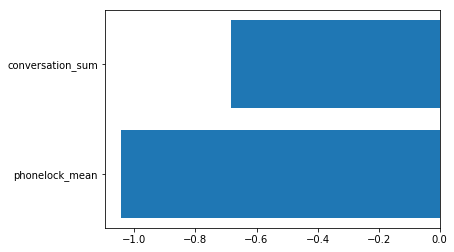

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

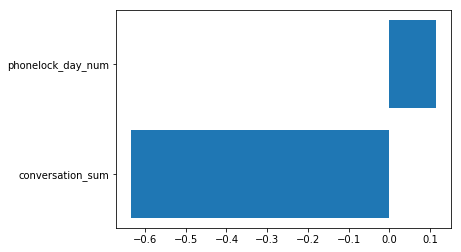

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

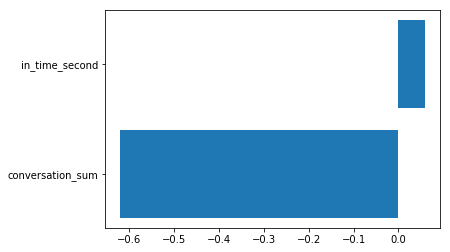

Train accuracy: 0.6333333333333333
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.27      0.75      0.40         4
           1       0.50      0.11      0.18         9

    accuracy                           0.31        13
   macro avg       0.39      0.43      0.29        13
weighted avg       0.43      0.31      0.25        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.43	23.91	0.31	0.18	0.50	0.11	

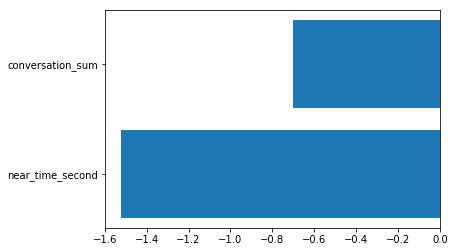

Train accuracy: 0.6333333333333333
Test accuracy: 0.23076923076923078
cv accuracies: [0.55555556 0.57142857 0.57142857 0.42857143]
min cv acc: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.25      0.75      0.38         4
           1       0.00      0.00      0.00         9

    accuracy                           0.23        13
   macro avg       0.12      0.38      0.19        13
weighted avg       0.08      0.23      0.12        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.38	26.57	0.23	0.00	0.00	0.00	

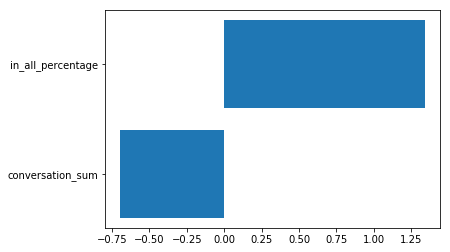

In [407]:
curr_cols, auc_score, min_cv_score, test_acc = feature_selector(X_flourishing, y_flourishing, [best_f], 
                 auc_score, min_cv_score, test_acc)

In [408]:
curr_cols, auc_score, min_cv_score, test_acc

(['conversation_sum'], 0.6041666666666667, 0.625, 0.5714285714285714)

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.44444444 0.57142857 0.57142857 0.57142857]
min cv acc: 0.4444444444444444
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

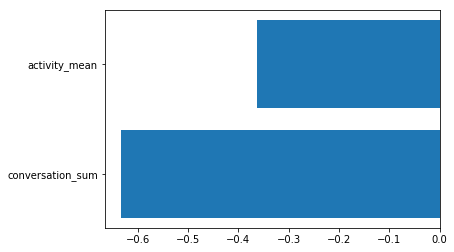

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

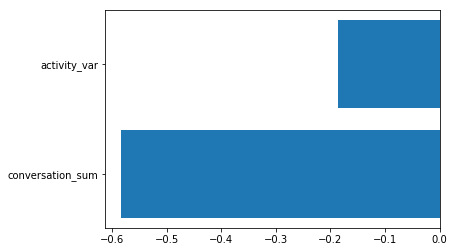

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

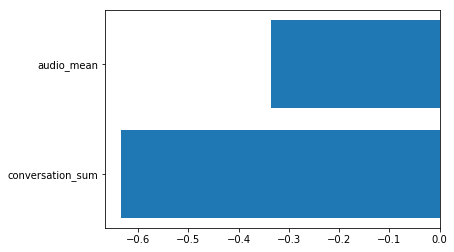

Train accuracy: 0.7
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.71428571 0.71428571]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.27      0.75      0.40         4
           1       0.50      0.11      0.18         9

    accuracy                           0.31        13
   macro avg       0.39      0.43      0.29        13
weighted avg       0.43      0.31      0.25        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.43	23.91	0.31	0.18	0.50	0.11	

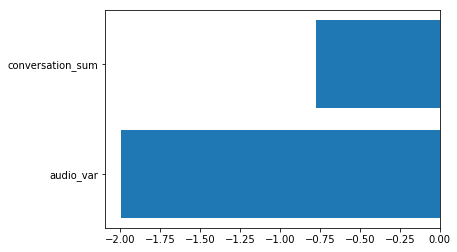

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

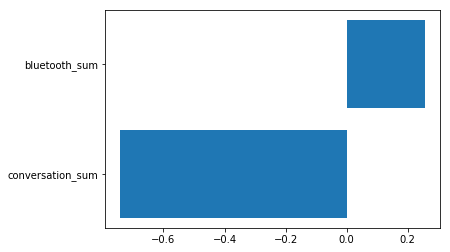

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, wa

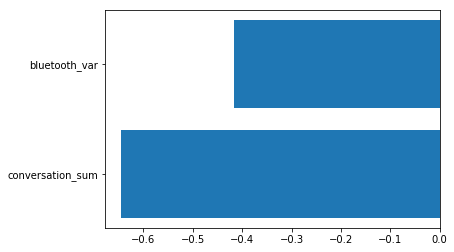

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13



/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

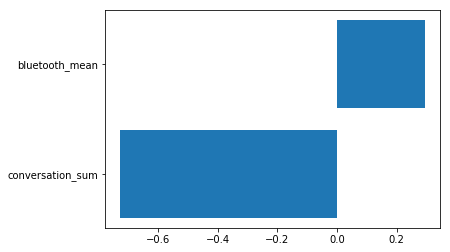

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

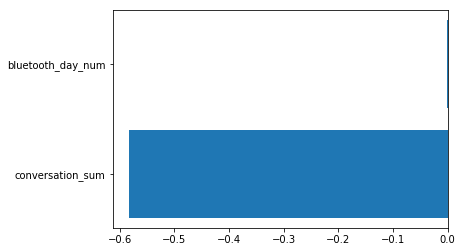

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

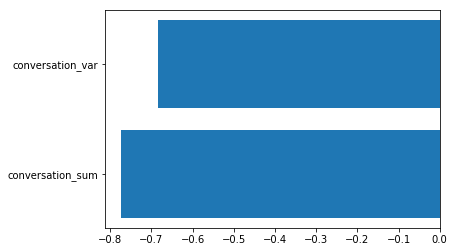

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr


0.50	23.91	0.31	0.00	0.00	0.00	

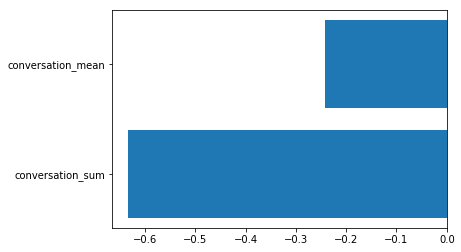

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

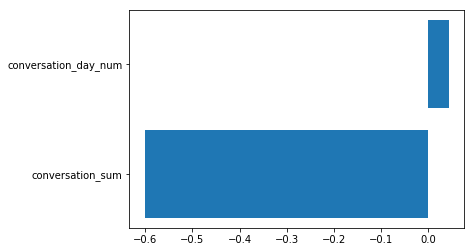

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

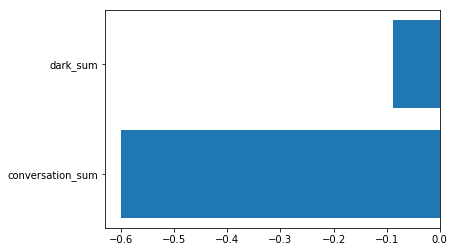

Train accuracy: 0.7666666666666667
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.85714286 0.71428571 0.85714286]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

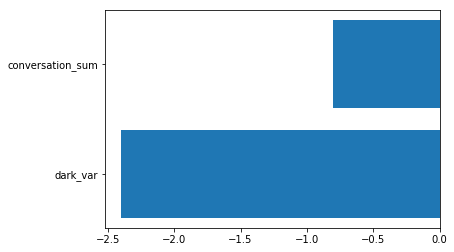

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

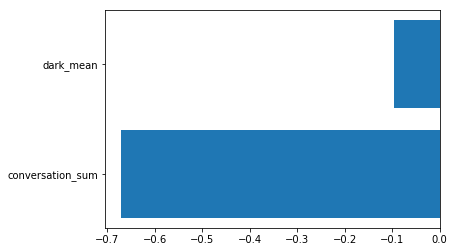

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

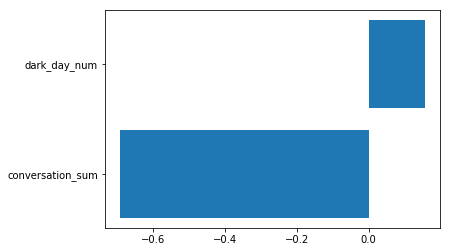

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

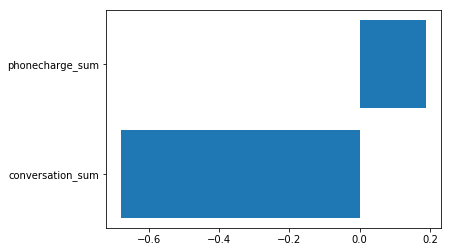

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

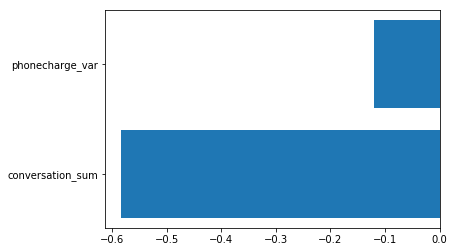

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

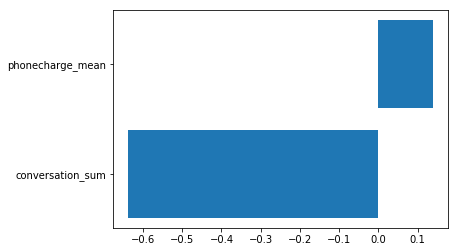

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

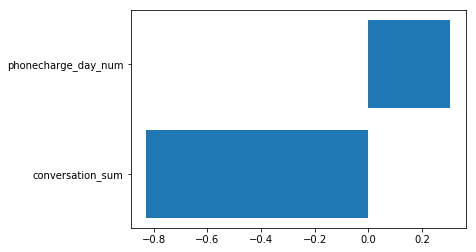

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13



/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

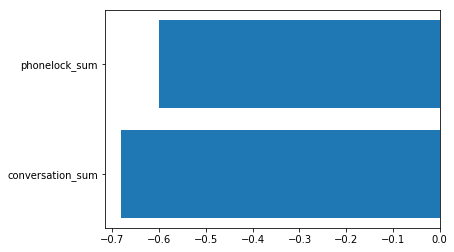

Train accuracy: 0.7
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.71428571 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

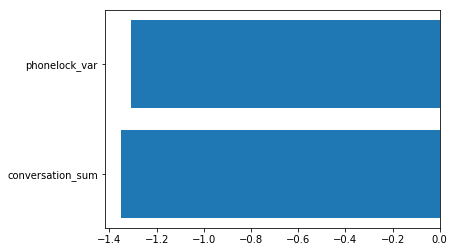

Train accuracy: 0.5333333333333333
Test accuracy: 0.3076923076923077
cv accuracies: [0.44444444 0.57142857 0.71428571 0.57142857]
min cv acc: 0.4444444444444444


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


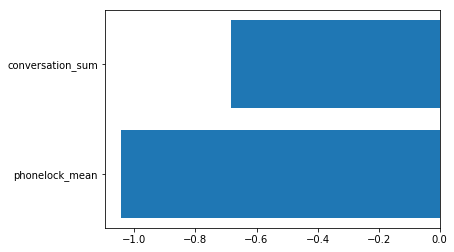

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

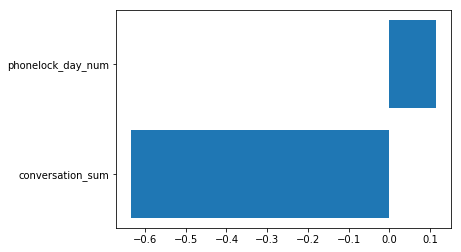

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

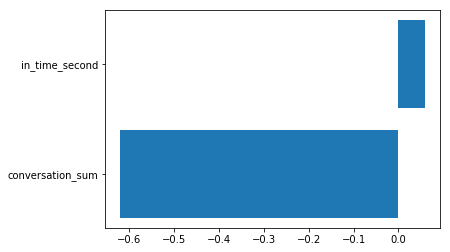

Train accuracy: 0.6333333333333333
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.27      0.75      0.40         4
           1       0.50      0.11      0.18         9

    accuracy                           0.31        13
   macro avg       0.39      0.43      0.29        13
weighted avg       0.43      0.31      0.25        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.43	23.91	0.31	0.18	0.50	0.11	

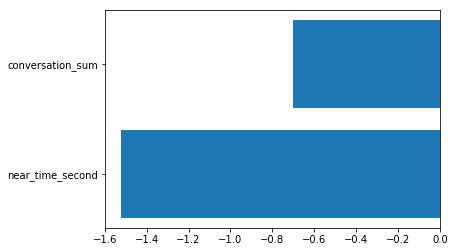

Train accuracy: 0.6333333333333333
Test accuracy: 0.23076923076923078
cv accuracies: [0.55555556 0.57142857 0.57142857 0.42857143]
min cv acc: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.25      0.75      0.38         4
           1       0.00      0.00      0.00         9

    accuracy                           0.23        13
   macro avg       0.12      0.38      0.19        13
weighted avg       0.08      0.23      0.12        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.38	26.57	0.23	0.00	0.00	0.00	

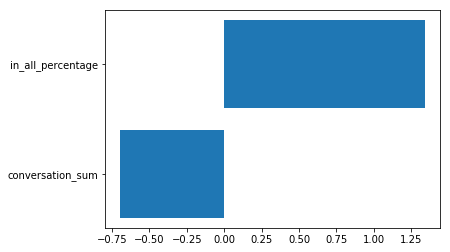

In [409]:
curr_cols, auc_score, min_cv_score, test_acc = feature_selector_equal(X_flourishing, y_flourishing, [best_f], 
                 auc_score, min_cv_score, test_acc)

In [410]:
curr_cols, auc_score, min_cv_score, test_acc

(['conversation_sum'], 0.6041666666666667, 0.625, 0.5714285714285714)

Train accuracy: 0.7
Test accuracy: 0.7142857142857143
cv accuracies: [0.75       0.75       0.5        0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.83      0.62      0.71         8

    accuracy                           0.71        14
   macro avg       0.73      0.73      0.71        14
weighted avg       0.74      0.71      0.71        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.73	9.87	0.71	0.71	0.83	0.62	

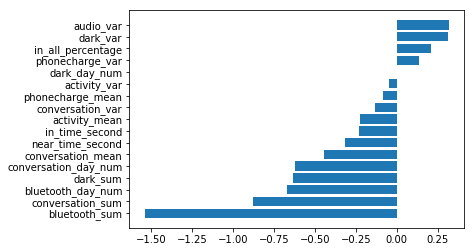

In [305]:
# best features
curr_feature = X_panas[curr_cols]
auc_score, min_cv_score, test_acc = pred_post_svc(curr_feature, y_panas_pos)

In [ ]:
# tune parameters

### PANAS negative

Train accuracy: 0.8
Test accuracy: 0.6428571428571429
cv accuracies: [0.375 0.625 0.625 0.5  ]
min cv acc: 0.375
              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.80      0.50      0.62         8

    accuracy                           0.64        14
   macro avg       0.68      0.67      0.64        14
weighted avg       0.70      0.64      0.64        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.67	12.34	0.64	0.62	0.80	0.50	

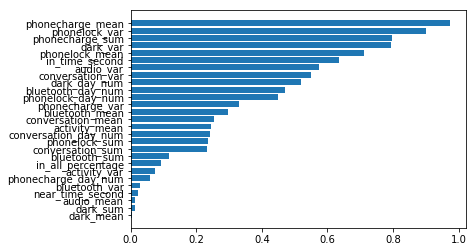

In [464]:
top_15_panas_neg, auc_score, min_cv_score, test_acc = pred_post_svc(X_panas, y_panas_neg)

Train accuracy: 0.5666666666666667
Test accuracy: 0.35714285714285715
cv accuracies: [0.5   0.625 0.5   0.5  ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.20      0.17      0.18         6
           1       0.44      0.50      0.47         8

    accuracy                           0.36        14
   macro avg       0.32      0.33      0.33        14
weighted avg       0.34      0.36      0.35        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.33	22.20	0.36	0.47	0.44	0.50	

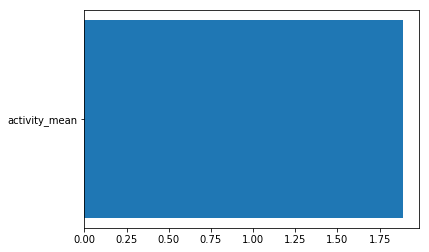

Train accuracy: 0.6666666666666666
Test accuracy: 0.42857142857142855
cv accuracies: [0.5        0.625      0.875      0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         6
           1       0.50      0.50      0.50         8

    accuracy                           0.43        14
   macro avg       0.42      0.42      0.42        14
weighted avg       0.43      0.43      0.43        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.42	19.74	0.43	0.50	0.50	0.50	

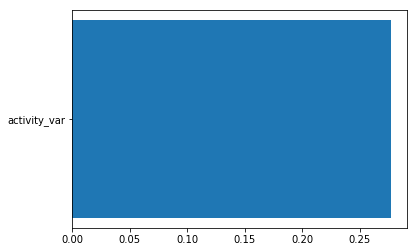

Train accuracy: 0.6333333333333333
Test accuracy: 0.42857142857142855
cv accuracies: [0.5  0.75 0.75 0.5 ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      0.75      0.60         8

    accuracy                           0.43        14
   macro avg       0.25      0.38      0.30        14
weighted avg       0.29      0.43      0.34        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.38	19.74	0.43	0.60	0.50	0.75	

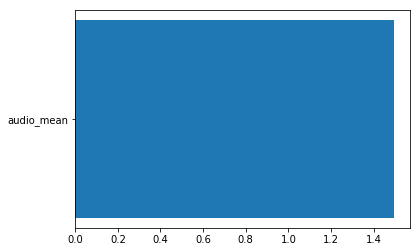

Train accuracy: 0.6666666666666666
Test accuracy: 0.35714285714285715
cv accuracies: [0.625 0.75  0.75  0.5  ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.45      0.62      0.53         8

    accuracy                           0.36        14
   macro avg       0.23      0.31      0.26        14
weighted avg       0.26      0.36      0.30        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.31	22.20	0.36	0.53	0.45	0.62	

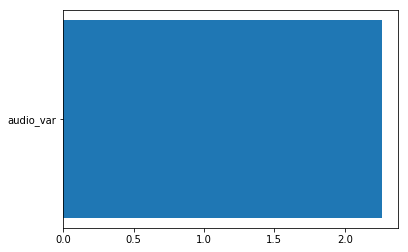

Train accuracy: 0.4
Test accuracy: 0.5714285714285714
cv accuracies: [0.375 0.375 0.25  0.5  ]
min cv acc: 0.25
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         6
           1       1.00      0.25      0.40         8

    accuracy                           0.57        14
   macro avg       0.75      0.62      0.53        14
weighted avg       0.79      0.57      0.51        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.62	14.80	0.57	0.40	1.00	0.25	

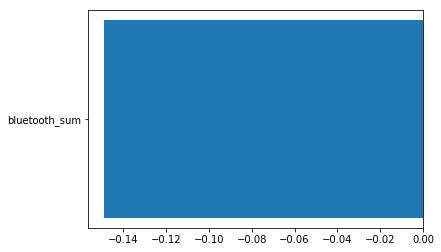

Train accuracy: 0.5666666666666667
Test accuracy: 0.7142857142857143
cv accuracies: [0.375      0.5        0.375      0.66666667]
min cv acc: 0.375
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       1.00      0.50      0.67         8

    accuracy                           0.71        14
   macro avg       0.80      0.75      0.71        14
weighted avg       0.83      0.71      0.70        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.75	9.87	0.71	0.67	1.00	0.50	

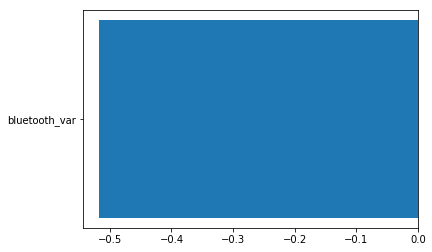

Train accuracy: 0.43333333333333335
Test accuracy: 0.6428571428571429
cv accuracies: [0.375 0.375 0.25  0.5  ]
min cv acc: 0.25
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       1.00      0.38      0.55         8

    accuracy                           0.64        14
   macro avg       0.77      0.69      0.63        14
weighted avg       0.81      0.64      0.61        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.69	12.34	0.64	0.55	1.00	0.38	

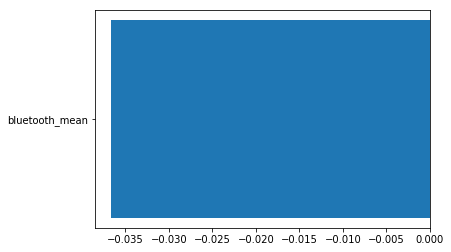

Train accuracy: 0.5333333333333333
Test accuracy: 0.5714285714285714
cv accuracies: [0.375      0.5        0.5        0.33333333]
min cv acc: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.60      0.75      0.67         8

    accuracy                           0.57        14
   macro avg       0.55      0.54      0.53        14
weighted avg       0.56      0.57      0.55        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.54	14.80	0.57	0.67	0.60	0.75	

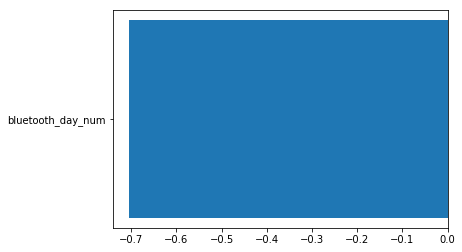

Train accuracy: 0.5333333333333333
Test accuracy: 0.2857142857142857
cv accuracies: [0.375      0.375      0.25       0.33333333]
min cv acc: 0.25
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.40      0.50      0.44         8

    accuracy                           0.29        14
   macro avg       0.20      0.25      0.22        14
weighted avg       0.23      0.29      0.25        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.25	24.67	0.29	0.44	0.40	0.50	

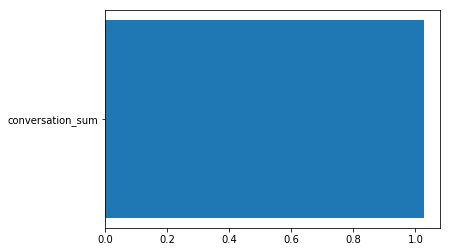

Train accuracy: 0.7
Test accuracy: 0.35714285714285715
cv accuracies: [0.75       0.75       0.875      0.33333333]
min cv acc: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.45      0.62      0.53         8

    accuracy                           0.36        14
   macro avg       0.23      0.31      0.26        14
weighted avg       0.26      0.36      0.30        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.31	22.20	0.36	0.53	0.45	0.62	

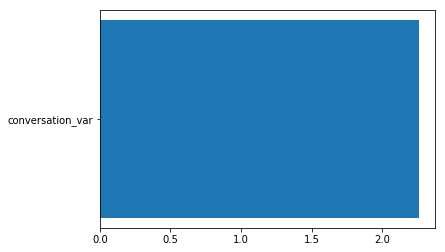

Train accuracy: 0.6333333333333333
Test accuracy: 0.2857142857142857
cv accuracies: [0.625 0.75  0.75  0.5  ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.40      0.50      0.44         8

    accuracy                           0.29        14
   macro avg       0.20      0.25      0.22        14
weighted avg       0.23      0.29      0.25        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.25	24.67	0.29	0.44	0.40	0.50	

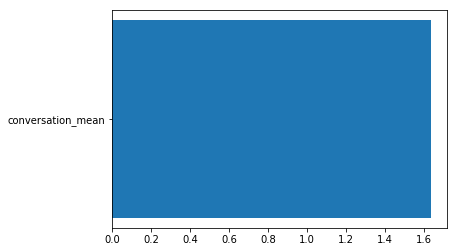

Train accuracy: 0.5666666666666667
Test accuracy: 0.5714285714285714
cv accuracies: [0.625      0.5        0.375      0.66666667]
min cv acc: 0.375
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.60      0.75      0.67         8

    accuracy                           0.57        14
   macro avg       0.55      0.54      0.53        14
weighted avg       0.56      0.57      0.55        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.54	14.80	0.57	0.67	0.60	0.75	

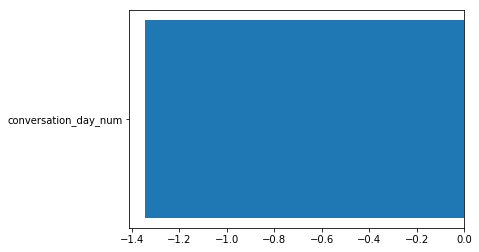

Train accuracy: 0.4666666666666667
Test accuracy: 0.5714285714285714
cv accuracies: [0.625      0.125      0.5        0.66666667]
min cv acc: 0.125
              precision    recall  f1-score   support

           0       0.50      0.83      0.62         6
           1       0.75      0.38      0.50         8

    accuracy                           0.57        14
   macro avg       0.62      0.60      0.56        14
weighted avg       0.64      0.57      0.55        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.60	14.80	0.57	0.50	0.75	0.38	

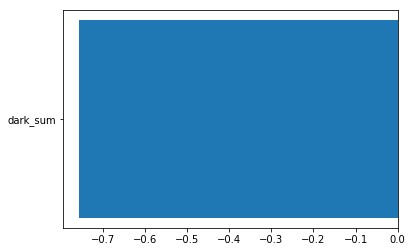

Train accuracy: 0.5
Test accuracy: 0.42857142857142855
cv accuracies: [0.625 0.25  0.375 0.5  ]
min cv acc: 0.25
              precision    recall  f1-score   support

           0       0.42      0.83      0.56         6
           1       0.50      0.12      0.20         8

    accuracy                           0.43        14
   macro avg       0.46      0.48      0.38        14
weighted avg       0.46      0.43      0.35        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.48	19.74	0.43	0.20	0.50	0.12	

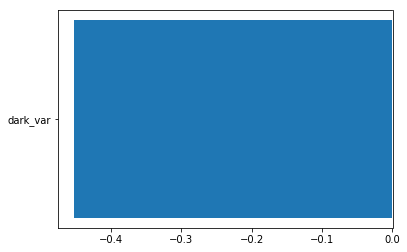

Train accuracy: 0.5
Test accuracy: 0.5
cv accuracies: [0.75  0.125 0.375 0.5  ]
min cv acc: 0.125
              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.57      0.50      0.53         8

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.51      0.50      0.50        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	17.27	0.50	0.53	0.57	0.50	

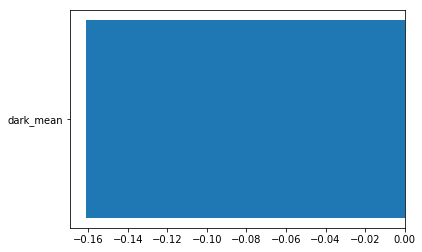

Train accuracy: 0.6
Test accuracy: 0.6428571428571429
cv accuracies: [0.625      0.375      0.5        0.83333333]
min cv acc: 0.375
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.71      0.62      0.67         8

    accuracy                           0.64        14
   macro avg       0.64      0.65      0.64        14
weighted avg       0.65      0.64      0.64        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.65	12.34	0.64	0.67	0.71	0.62	

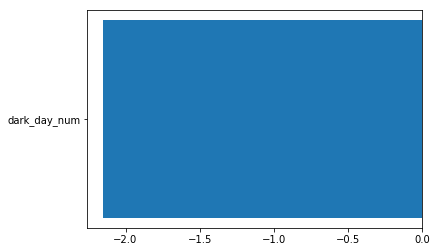

Train accuracy: 0.7666666666666667
Test accuracy: 0.5714285714285714
cv accuracies: [0.625      0.625      0.75       0.66666667]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         6
           1       1.00      0.25      0.40         8

    accuracy                           0.57        14
   macro avg       0.75      0.62      0.53        14
weighted avg       0.79      0.57      0.51        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.62	14.80	0.57	0.40	1.00	0.25	

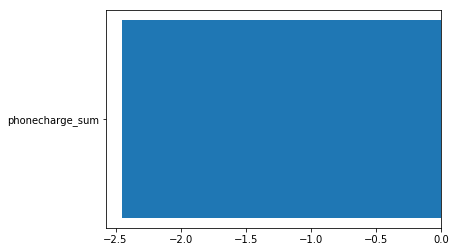

Train accuracy: 0.6333333333333333
Test accuracy: 0.42857142857142855
cv accuracies: [0.625      0.625      0.625      0.66666667]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.42      0.83      0.56         6
           1       0.50      0.12      0.20         8

    accuracy                           0.43        14
   macro avg       0.46      0.48      0.38        14
weighted avg       0.46      0.43      0.35        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.48	19.74	0.43	0.20	0.50	0.12	

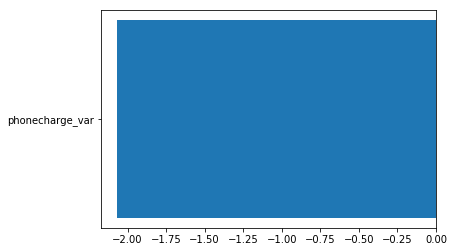

Train accuracy: 0.6666666666666666
Test accuracy: 0.6428571428571429
cv accuracies: [0.75       0.5        0.75       0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       1.00      0.38      0.55         8

    accuracy                           0.64        14
   macro avg       0.77      0.69      0.63        14
weighted avg       0.81      0.64      0.61        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.69	12.34	0.64	0.55	1.00	0.38	

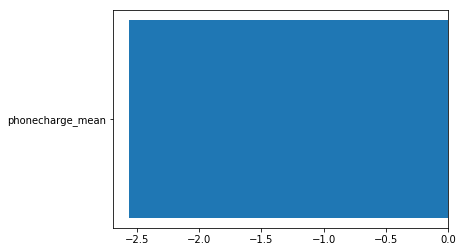

Train accuracy: 0.6
Test accuracy: 0.7142857142857143
cv accuracies: [0.75       0.5        0.5        0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.75      0.75      0.75         8

    accuracy                           0.71        14
   macro avg       0.71      0.71      0.71        14
weighted avg       0.71      0.71      0.71        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.71	9.87	0.71	0.75	0.75	0.75	

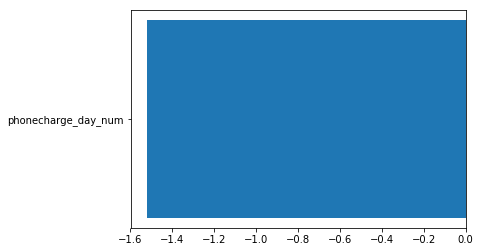

Train accuracy: 0.5333333333333333
Test accuracy: 0.42857142857142855
cv accuracies: [0.25       0.25       0.5        0.33333333]
min cv acc: 0.25
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         6
           1       0.50      0.50      0.50         8

    accuracy                           0.43        14
   macro avg       0.42      0.42      0.42        14
weighted avg       0.43      0.43      0.43        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.42	19.74	0.43	0.50	0.50	0.50	

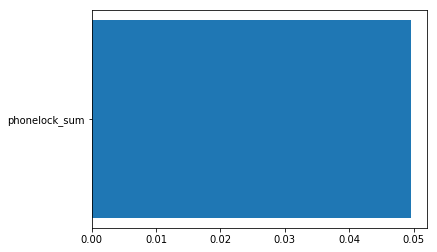

Train accuracy: 0.6666666666666666
Test accuracy: 0.7142857142857143
cv accuracies: [0.75       0.75       0.375      0.83333333]
min cv acc: 0.375
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.83      0.62      0.71         8

    accuracy                           0.71        14
   macro avg       0.73      0.73      0.71        14
weighted avg       0.74      0.71      0.71        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.73	9.87	0.71	0.71	0.83	0.62	

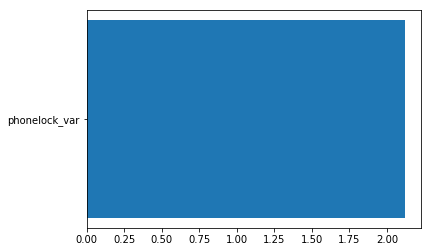

Train accuracy: 0.6333333333333333
Test accuracy: 0.5714285714285714
cv accuracies: [0.5        0.75       0.75       0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.62      0.62      0.62         8

    accuracy                           0.57        14
   macro avg       0.56      0.56      0.56        14
weighted avg       0.57      0.57      0.57        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	14.80	0.57	0.62	0.62	0.62	

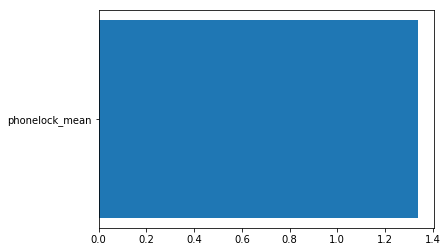

Train accuracy: 0.6
Test accuracy: 0.5714285714285714
cv accuracies: [0.625      0.5        0.5        0.66666667]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.60      0.75      0.67         8

    accuracy                           0.57        14
   macro avg       0.55      0.54      0.53        14
weighted avg       0.56      0.57      0.55        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.54	14.80	0.57	0.67	0.60	0.75	

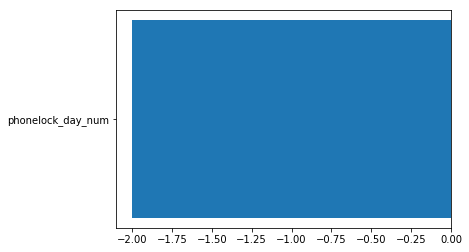

Train accuracy: 0.6333333333333333
Test accuracy: 0.6428571428571429
cv accuracies: [0.625 0.625 0.75  0.5  ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.62      1.00      0.76         8

    accuracy                           0.64        14
   macro avg       0.81      0.58      0.52        14
weighted avg       0.78      0.64      0.56        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.58	12.34	0.64	0.76	0.62	1.00	

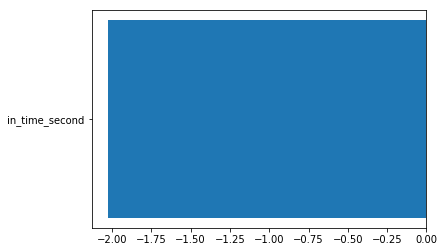

Train accuracy: 0.5333333333333333
Test accuracy: 0.7857142857142857
cv accuracies: [0.625 0.5   0.625 0.5  ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.73      1.00      0.84         8

    accuracy                           0.79        14
   macro avg       0.86      0.75      0.75        14
weighted avg       0.84      0.79      0.77        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.75	7.40	0.79	0.84	0.73	1.00	

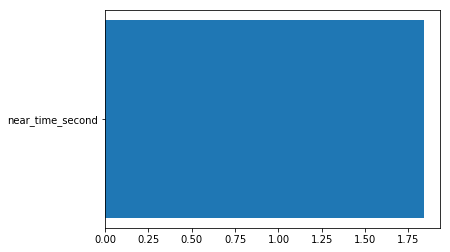

Train accuracy: 0.5333333333333333
Test accuracy: 0.7857142857142857
cv accuracies: [0.625 0.5   0.625 0.5  ]
min cv acc: 0.5
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.73      1.00      0.84         8

    accuracy                           0.79        14
   macro avg       0.86      0.75      0.75        14
weighted avg       0.84      0.79      0.77        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.75	7.40	0.79	0.84	0.73	1.00	

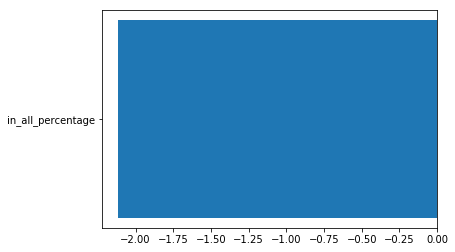

In [412]:
best_f, auc_score, min_cv_score, test_acc = find_best_feature(X_panas, y_panas_neg)
    

In [413]:
best_f, auc_score, min_cv_score, test_acc

('phonecharge_sum', 0.625, 0.625, 0.5714285714285714)

Train accuracy: 0.7666666666666667
Test accuracy: 0.5714285714285714
cv accuracies: [0.625      0.625      0.75       0.66666667]
min cv acc: 0.625
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         6
           1       1.00      0.25      0.40         8

    accuracy                           0.57        14
   macro avg       0.75      0.62      0.53        14
weighted avg       0.79      0.57      0.51        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.62	14.80	0.57	0.40	1.00	0.25	

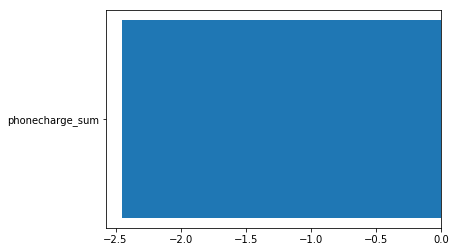

(0.625, 0.625, 0.5714285714285714)

In [414]:
pred_post_svc(X_panas[[best_f]], y_panas_neg)

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

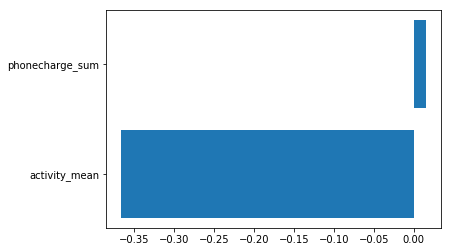

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

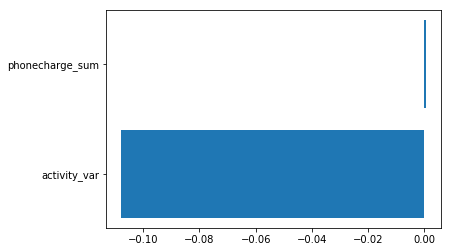

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

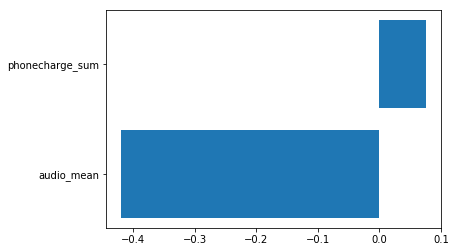

Train accuracy: 0.7
Test accuracy: 0.23076923076923078
cv accuracies: [0.55555556 0.57142857 0.71428571 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.25      0.75      0.38         4
           1       0.00      0.00      0.00         9

    accuracy                           0.23        13
   macro avg       0.12      0.38      0.19        13
weighted avg       0.08      0.23      0.12        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.38	26.57	0.23	0.00	0.00	0.00	

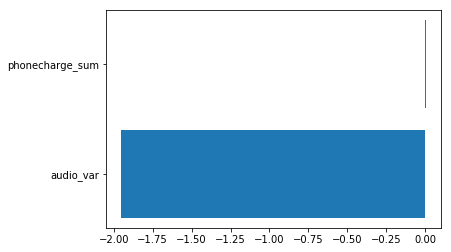

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

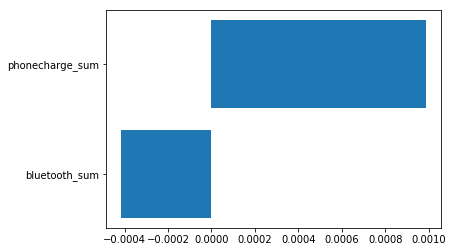

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

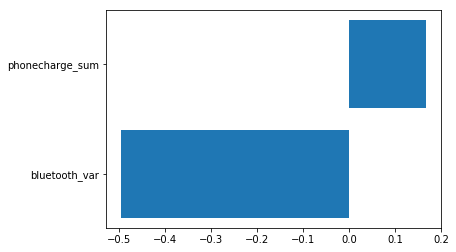

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

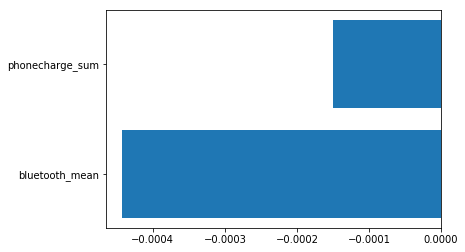

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


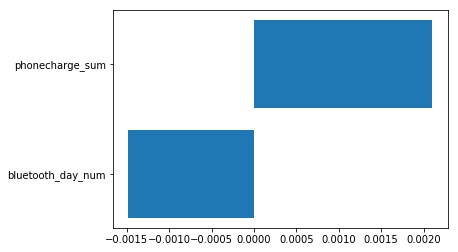

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, wa

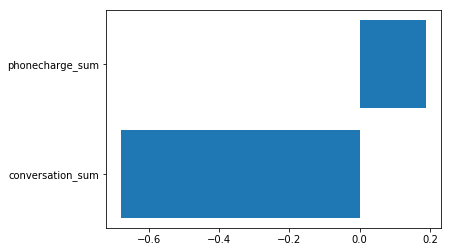

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr


0.50	23.91	0.31	0.00	0.00	0.00	

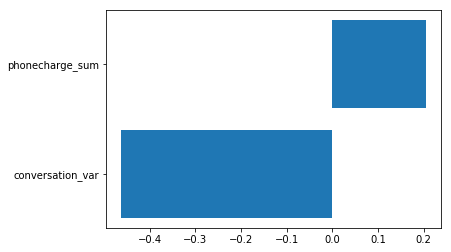

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

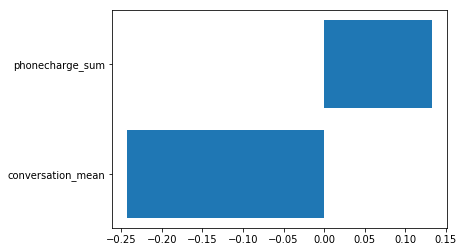

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


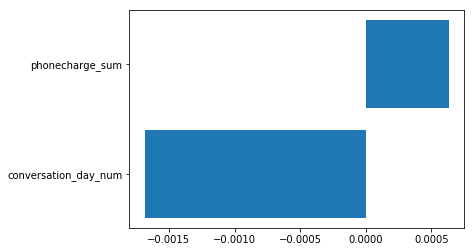

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

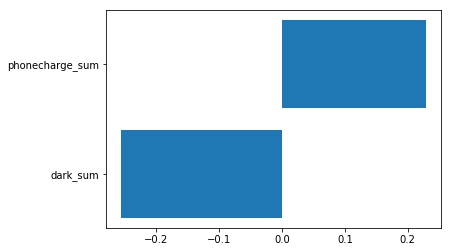

Train accuracy: 0.7333333333333333
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.71428571 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

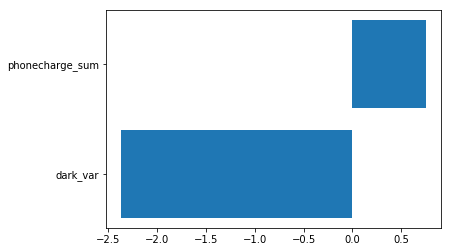

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

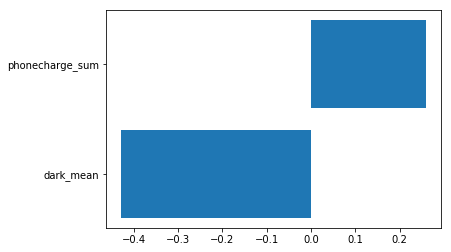

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

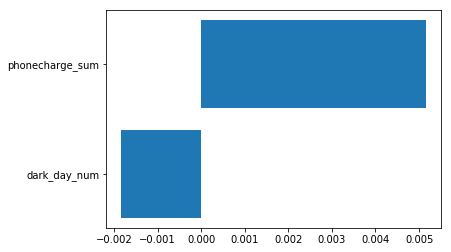

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

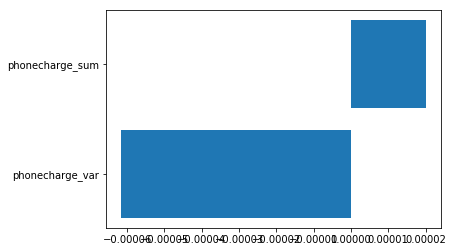

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, wa

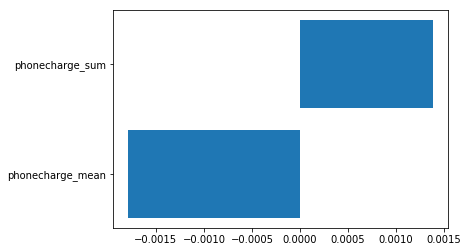

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

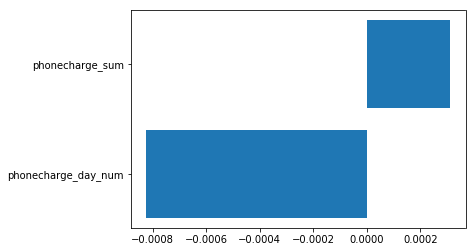

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

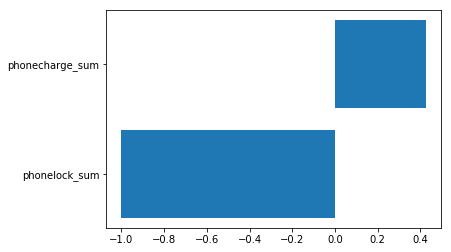

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

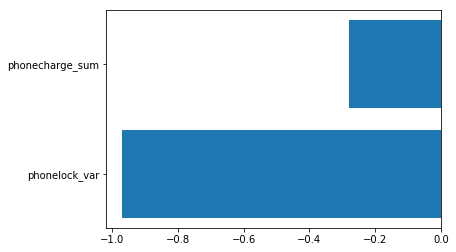

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

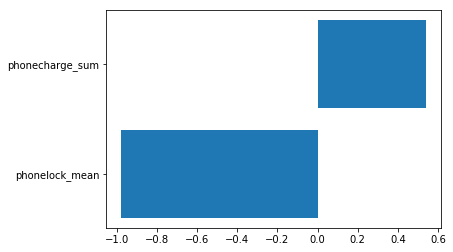

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

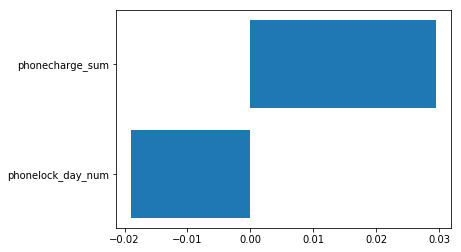

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

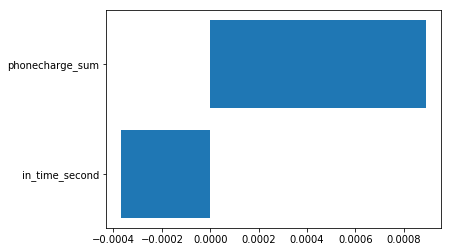

Train accuracy: 0.6
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.42857143]
min cv acc: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.27      0.75      0.40         4
           1       0.50      0.11      0.18         9

    accuracy                           0.31        13
   macro avg       0.39      0.43      0.29        13
weighted avg       0.43      0.31      0.25        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.43	23.91	0.31	0.18	0.50	0.11	

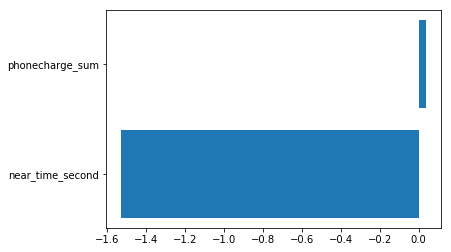

Train accuracy: 0.6
Test accuracy: 0.23076923076923078
cv accuracies: [0.55555556 0.57142857 0.57142857 0.42857143]
min cv acc: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.25      0.75      0.38         4
           1       0.00      0.00      0.00         9

    accuracy                           0.23        13
   macro avg       0.12      0.38      0.19        13
weighted avg       0.08      0.23      0.12        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.38	26.57	0.23	0.00	0.00	0.00	

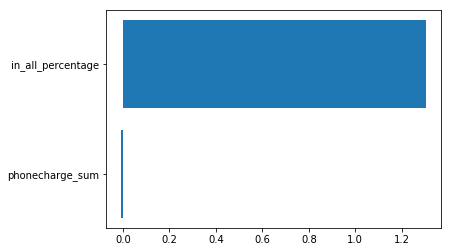

In [415]:
curr_cols, auc_score, min_cv_score, test_acc = feature_selector(X_flourishing, y_flourishing, [best_f], 
                 auc_score, min_cv_score, test_acc)

In [416]:
curr_cols, auc_score, min_cv_score, test_acc

(['phonecharge_sum'], 0.625, 0.625, 0.5714285714285714)

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

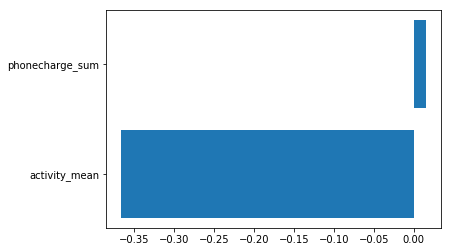

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

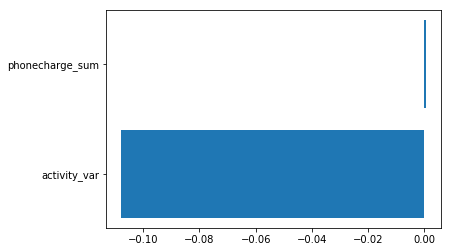

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13



/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

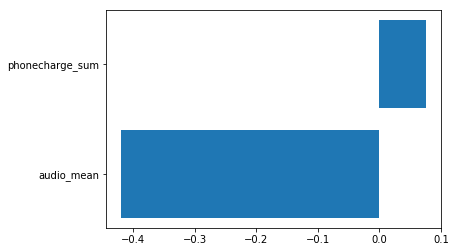

Train accuracy: 0.7
Test accuracy: 0.23076923076923078
cv accuracies: [0.55555556 0.57142857 0.71428571 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.25      0.75      0.38         4
           1       0.00      0.00      0.00         9

    accuracy                           0.23        13
   macro avg       0.12      0.38      0.19        13
weighted avg       0.08      0.23      0.12        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.38	26.57	0.23	0.00	0.00	0.00	

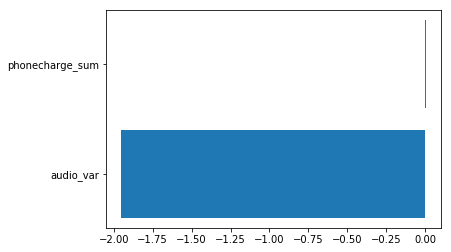

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

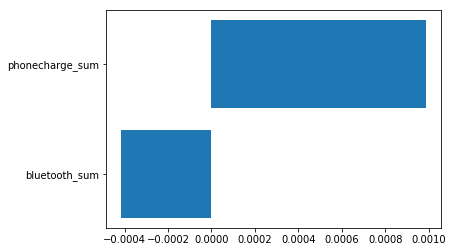

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

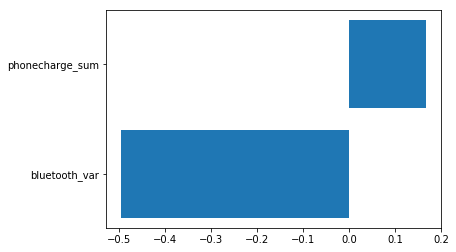

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

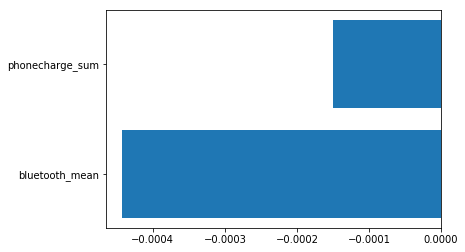

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

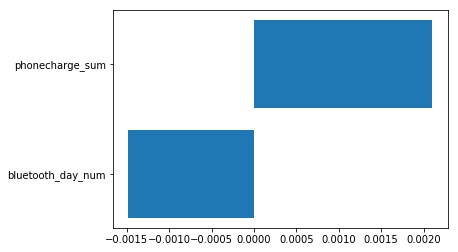

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, wa

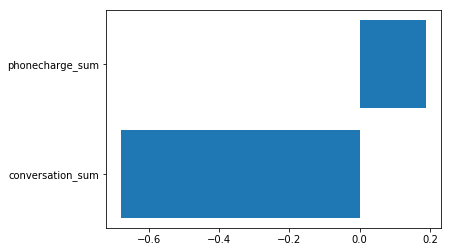

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

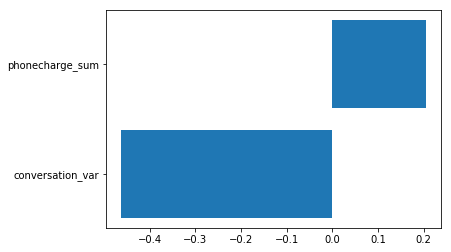

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

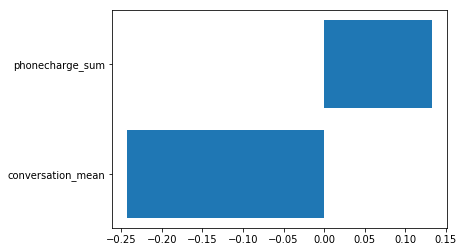

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies:

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

 [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


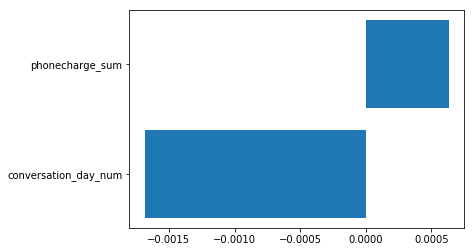

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

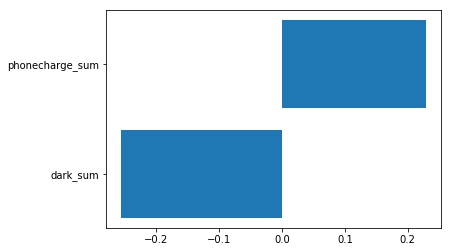

Train accuracy: 0.7333333333333333
Test accuracy: 0.38461538461538464
cv accuracies: [0.66666667 0.71428571 0.71428571 0.71428571]
min cv acc: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         4
           1       1.00      0.11      0.20         9

    accuracy                           0.38        13
   macro avg       0.67      0.56      0.35        13
weighted avg       0.79      0.38      0.29        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.56	21.25	0.38	0.20	1.00	0.11	

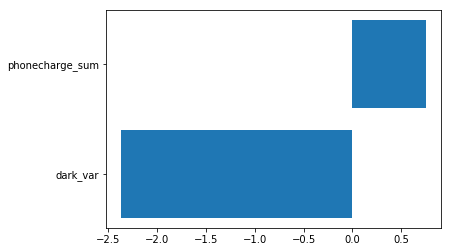

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

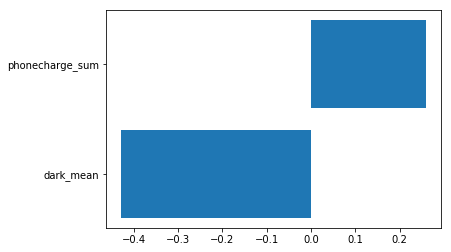

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

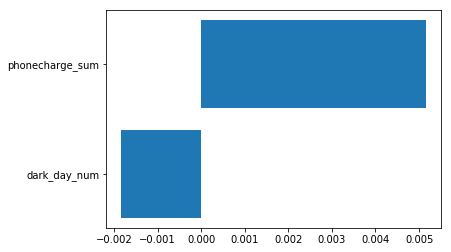

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13



/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

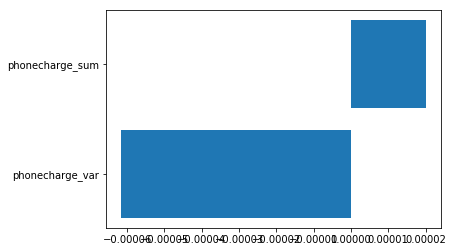

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

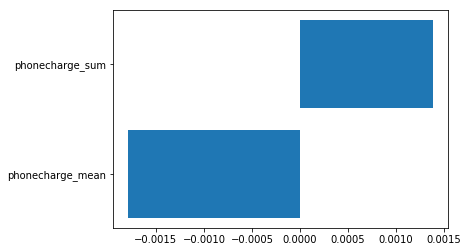

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13



/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

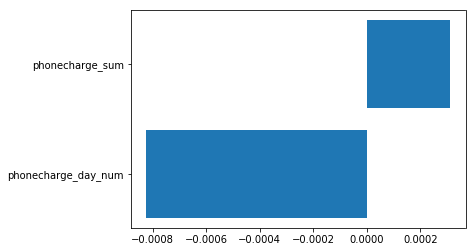

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

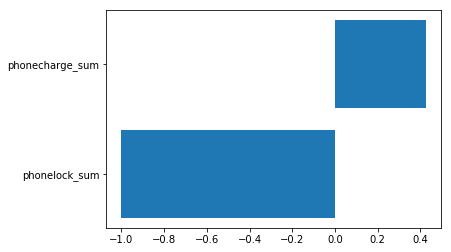

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077


/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

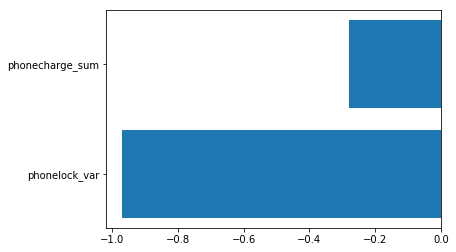

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

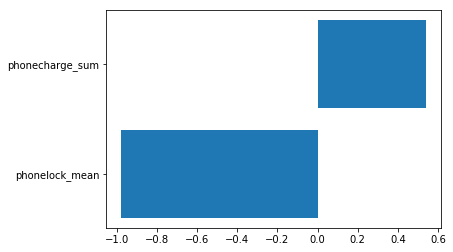

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies:

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

 [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

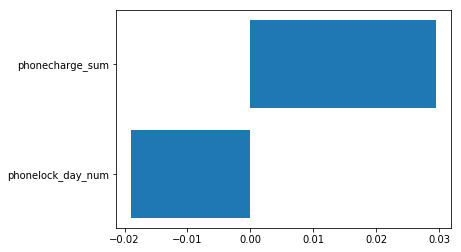

Train accuracy: 0.5666666666666667
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.57142857]
min cv acc: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.00      0.00      0.00         9

    accuracy                           0.31        13
   macro avg       0.15      0.50      0.24        13
weighted avg       0.09      0.31      0.14        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.50	23.91	0.31	0.00	0.00	0.00	

/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wenke_yang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

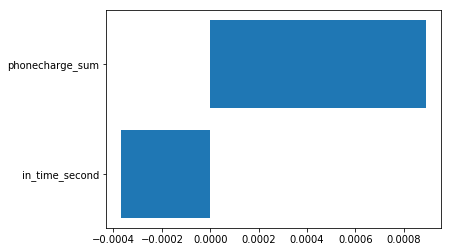

Train accuracy: 0.6
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.57142857 0.57142857 0.42857143]
min cv acc: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.27      0.75      0.40         4
           1       0.50      0.11      0.18         9

    accuracy                           0.31        13
   macro avg       0.39      0.43      0.29        13
weighted avg       0.43      0.31      0.25        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.43	23.91	0.31	0.18	0.50	0.11	

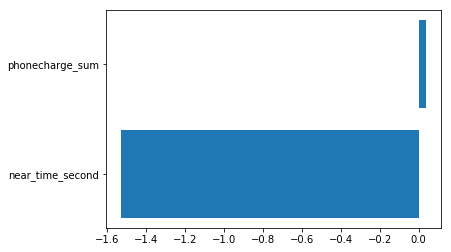

Train accuracy: 0.6
Test accuracy: 0.23076923076923078
cv accuracies: [0.55555556 0.57142857 0.57142857 0.42857143]
min cv acc: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.25      0.75      0.38         4
           1       0.00      0.00      0.00         9

    accuracy                           0.23        13
   macro avg       0.12      0.38      0.19        13
weighted avg       0.08      0.23      0.12        13

auc_score, logloss, accuracy, F_Measure, precision, recall
0.38	26.57	0.23	0.00	0.00	0.00	

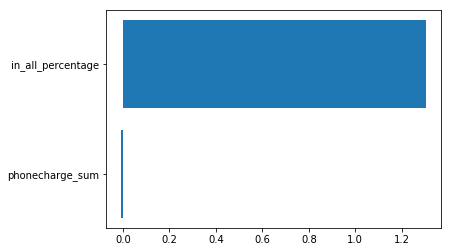

In [417]:
curr_cols, auc_score, min_cv_score, test_acc = feature_selector_equal(X_flourishing, y_flourishing, [best_f], 
                 auc_score, min_cv_score, test_acc)

In [424]:
curr_cols, auc_score, min_cv_score, test_acc

(['phonecharge_sum'], 0.625, 0.625, 0.5714285714285714)

In [460]:
def try_top_15_features(X, y, curr_cols=[], auc_score=0, min_cv_score=0, test_acc=0):
    best_features = curr_cols

    for i in range(1, len(X.columns)):
        comb_i = combinations(X.columns, i)
        for comb in comb_i:
            features = list(comb)
            curr_auc, curr_min_cv, curr_test_acc = pred_post_svc_no_output(X[features], 
                                                                        y)
            if curr_auc >= auc_score and curr_min_cv >= min_cv_score and \
                    curr_test_acc >= test_acc:
                auc_score = curr_auc
                min_cv_score = curr_min_cv
                test_acc = curr_test_acc
                best_features = features
    return best_features, auc_score, min_cv_score, test_acc
        

In [466]:
import time
t1 = time.time()
best_features, auc_score, min_cv_score, test_acc = try_top_15_features(X_panas[top_15_panas_neg],
                                                                       y_panas_neg)
print(time.time() - t1)

255.18664598464966


In [480]:
import random

f15 = list(X_flourishing.columns)
random.shuffle(f15)
f15 = list(f15[:15])
f15

['phonelock_var',
 'phonelock_sum',
 'bluetooth_mean',
 'bluetooth_var',
 'bluetooth_day_num',
 'conversation_day_num',
 'bluetooth_sum',
 'phonecharge_var',
 'conversation_mean',
 'dark_var',
 'phonelock_mean',
 'phonecharge_sum',
 'audio_var',
 'phonecharge_mean',
 'phonelock_day_num']

In [481]:
t1 = time.time()

best_features, auc_score, min_cv_score, test_acc = try_top_15_features(X_flourishing[f15],
                                                                       y_flourishing)
print(time.time() - t1)

477.18590474128723


In [482]:
best_features, auc_score, min_cv_score, test_acc

(['phonelock_var',
  'phonelock_sum',
  'bluetooth_mean',
  'conversation_day_num',
  'bluetooth_sum',
  'conversation_mean',
  'dark_var',
  'phonelock_mean',
  'phonecharge_sum'],
 0.6666666666666666,
 0.7142857142857143,
 0.5384615384615384)

In [483]:
t1 = time.time()
best_features, auc_score, min_cv_score, test_acc = try_top_15_features(X_panas[f15],
                                                                       y_panas_pos)
print(time.time() - t1)

623.2807290554047


In [484]:
best_features, auc_score, min_cv_score, test_acc

(['phonelock_var',
  'conversation_day_num',
  'phonecharge_var',
  'conversation_mean',
  'dark_var',
  'phonecharge_sum',
  'audio_var',
  'phonecharge_mean'],
 0.7916666666666667,
 0.625,
 0.7857142857142857)

In [467]:
best_features, auc_score, min_cv_score, test_acc

(['phonelock_day_num', 'conversation_var', 'phonecharge_mean'],
 0.875,
 0.6666666666666666,
 0.8571428571428571)

In [462]:
best_features, auc_score, min_cv_score, test_acc

(['phonelock_mean', 'conversation_var', 'bluetooth_var', 'dark_var'],
 0.6111111111111112,
 0.8571428571428571,
 0.46153846153846156)

In [427]:
best_features

['conversation_var',
 'phonecharge_mean',
 'phonelock_day_num',
 'near_time_second']

Train accuracy: 0.8333333333333334
Test accuracy: 0.8571428571428571
cv accuracies: [0.75 0.75 0.75 1.  ]
min cv acc: 0.75
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.75      0.86         8

    accuracy                           0.86        14
   macro avg       0.88      0.88      0.86        14
weighted avg       0.89      0.86      0.86        14

auc_score, logloss, accuracy, F_Measure, precision, recall
0.88	4.93	0.86	0.86	1.00	0.75	

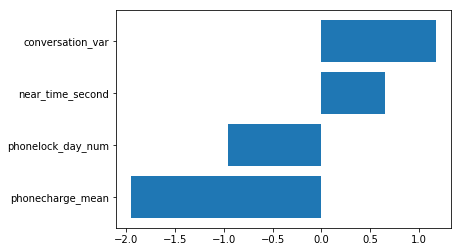

(0.875, 0.75, 0.8571428571428571)

In [428]:
pred_post_svc(X_panas[best_features], y_panas_neg)

In [202]:
# ref: https://www.geeksforgeeks.org/ml-principal-component-analysispca/
# Importing standardscalar module  
from sklearn.preprocessing import StandardScaler 
  
scalar = StandardScaler() 
  
# fitting 
scalar.fit(X_flourishing) 
scaled_data = scalar.transform(X_flourishing) 
  
# Importing PCA 
from sklearn.decomposition import PCA 
  
# Let's say, components = 2 
pca = PCA(n_components = 10) 
pca.fit(scaled_data) 
x_pca = pca.transform(scaled_data) 
  
x_pca.shape 

(43, 10)

In [205]:
#pca.components_

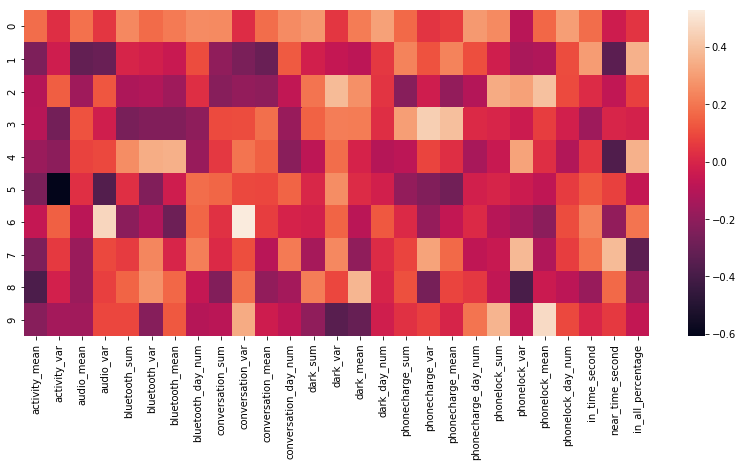

In [204]:
import seaborn as sns 
df_comp = pd.DataFrame(pca.components_, columns = X_flourishing.columns) 
  
plt.figure(figsize =(14, 6)) 
  
# plotting heatmap 
sns.heatmap(df_comp) 

In [87]:
import random
random_feature = []
for i in range(len(X_flourishing)):
    random_feature.append(random.randint(0,1))

Train accuracy: 0.6333333333333333
Test accuracy: 0.3076923076923077
cv accuracies: [0.55555556 0.71428571 0.71428571 0.28571429]
min cv acc: 0.2857142857142857
              precision    recall  f1-score   support

           0       0.22      0.50      0.31         4
           1       0.50      0.22      0.31         9

    accuracy                           0.31        13
   macro avg       0.36      0.36      0.31        13
weighted avg       0.41      0.31      0.31        13



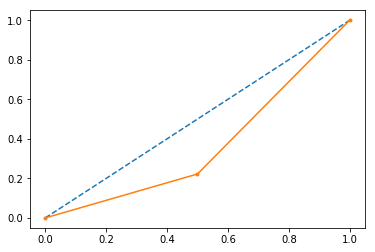

AUC: 0.361


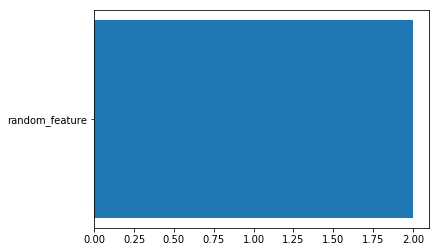

In [109]:
X1 = pd.DataFrame(random_feature, columns = ['random_feature'])
classifier = pred_post_svc(X1, y_flourishing)
feature_names = X1.columns
feature_importances(classifier.coef_[0], feature_names)